In [1]:
# %reset -f
import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import pickle as pkl

#Interpolation of points
from scipy.interpolate import griddata


# Plotting preparation
import sys
sys.path.append('../')
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [2]:
pi2=np.pi*2
%matplotlib notebook
dir_save = '01_Output/'
pltdir = '03_Plots'

# Transverse feedback

<IPython.core.display.Javascript object>


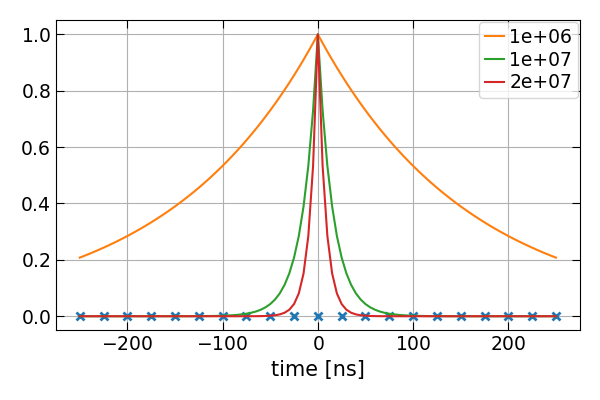

<IPython.core.display.Javascript object>


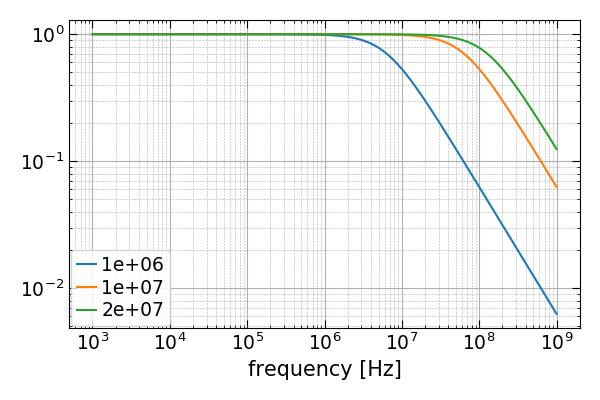

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [3]:
dt = 25e-9

t_bunch = np.arange(-10,11)*dt
ts = np.linspace(-10*dt,10*dt,101)
freq = np.logspace(3,9,100)
fco = np.array([1e3,1e4,1e5,1e6,1e7,2e7])
wco = fco*2*np.pi

fig1,ax1=plt.subplots(1)
fig2,ax2=plt.subplots(1)
ax1.plot(t_bunch*1e9,0*t_bunch,'x')
for i in range(3,6):
    label="%.0e"%fco[i]
    ax1.plot(ts*1e9,np.exp(-wco[i]*np.abs(ts)),label=label)
    ax2.loglog(freq,np.abs(1j*wco[i]/(1j*freq+wco[i])),label=label)

for iax,ax in enumerate([ax1,ax2]):
    ax.legend()
    ax.set_xlabel([r'time [ns]',r'frequency [Hz]'][iax])
    ax.grid(1,which='major')
    ax.grid(1,which='minor',ls='--',lw=0.4)
    fig=[fig1,fig2][iax]
    fig.tight_layout()
    

# Low BW weighting

In [4]:
np.log(0.113458834)


-2.176315203886037

In [5]:
np.sinc(1)
np.heaviside(2,3)

1.0

[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9]
5.449220020208022 -2.7861025885745966e-05 (0.9999999999987663-1.5707963267942506e-06j)
5.449220020208023 5.449220020208022
5.449199777987844 5.449199777987842
5.449134272787326 5.449134272787324
5.44930576762872 5.4493057676287195
5.449240262428203 5.4492402624282015
5.449220020208023 5.449220020208022
5.449199777987844 5.449199777987843
5.449134272787325 5.449134272787325
5.44930576762872 5.4493057676287195
5.449240262428203 5.4492402624282015


<IPython.core.display.Javascript object>


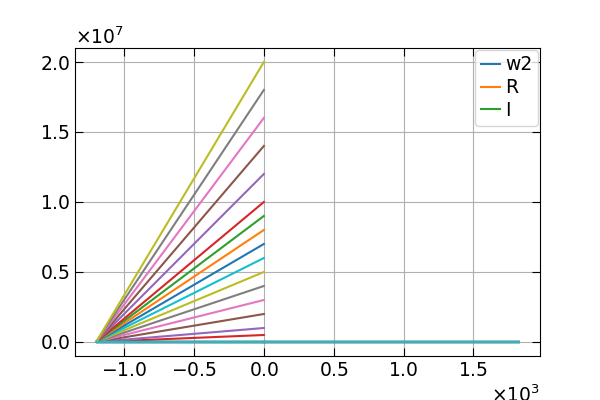

[5.449-0.j    5.449-0.j    5.449-0.j    5.449-0.j    5.449-0.j
 5.449-0.001j 5.449-0.01j  5.448-0.074j 5.399-0.569j 3.055-3.033j]


In [6]:
fco = 1e6
wco = fco*2*np.pi
dt = 25e-9

fc = 1e1
wc = fc*2*np.pi
phi0 = np.pi*.4

def weight(b,wco=wco,dt=dt,mode=0):
    if mode==0:
        ans = np.array(np.exp(-wco*dt*b))
        ans[b<0] = 0
        return ans
#         return np.exp(-wco*dt*np.abs(b))*(1+1*(b==0))/2
    elif mode==1:
        return spec.k0(wco*dt*np.abs(b))#/spec.k0(0)
    elif mode==2:
        return np.exp(-(wco*dt*b)**2)
    elif mode==3:
        return np.exp(-np.abs(b)*wco*dt)
    elif mode ==4:
        return np.sinc(b*dt*wco/np.pi)
    
    
def transfer_function(w,wco,dt,mode=0):
    
    if mode == 0:
        return 1/(1+1j*w/wco)
    
    elif mode==3:
        return 2/(1 + (w/wco)**2)
    elif mode ==4:
        ans = np.pi*np.ones_like(w)
        ans[w>wco]=0
        return ans
    else: 
        return np.nan
    
def phase(b,wc=wc,dt=dt):
    return np.exp(-1j*(wc*dt*b))



bmax= 10
b = np.arange(-bmax+1,bmax,1)
print(b)
bi = np.linspace(-bmax+1,bmax-1,101)

weights = weight(b)
func = (-1+(1-weight( bmax)*phase( bmax))/(1-weight( 1)*phase( 1))
                         +(1-weight(-bmax)*phase(-bmax))/(1-weight(-1)*phase(-1)))

print(func.real,func.imag,phase(1))
for i in range(10):
    phi0 = 2*np.pi*i/10
    phase0 = np.exp(-1j*phi0)
    phases = phase(b) * phase0
    sumall    =phase0*func
    print(np.real(np.sum(weights*phases/np.real(phase0))),np.real(sumall)/np.real(phase0) ) #,np.real(sumphases))

# sumweights= -1+2*np.sum(weights)
# print(sumweights)
# sumphases = -1+2*phase0*(1-phase(bmax))/(1-phase(1))


plt.figure()
# plt.plot(bi,weight(bi),label='w')
plt.plot(bi,weight(bi,mode=1),label='w2')
plt.plot(b,phases.real,label='R')
plt.plot(b,phases.imag,label='I')
plt.legend(loc=0)
plt.grid(True)

wcs = np.logspace(-1,7,10)
funcs = (-1+(1-weight( bmax)*phase( bmax,wc=wcs))/(1-weight( 1)*phase( 1,wc=wcs))
                  +(1-weight(-bmax)*phase(-bmax,wc=wcs))/(1-weight(-1)*phase(-1,wc=wcs)))
print(funcs)


# Weight file

## Create exponential file

In [829]:
fcos = 1e6*np.array([0.5,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,100])
nf = np.size(fcos)

flag_120MHz = 0
factor_120 = [1,3][flag_120MHz]

ADT_ntaphalf =500*factor_120
Ncol = ADT_ntaphalf*2 +1
Nrow = nf+1
dt = 25e-9/factor_120 #ns
t = np.arange(-ADT_ntaphalf,ADT_ntaphalf+.1)*dt
print(t*1e9)

weight_array = np.zeros((Ncol+1,Nrow))
weight_array[1:,0] = t*1e9
weight_array[0,1:] = fcos
for i,fco in enumerate(fcos):
    weight_array[1:,1+i] = np.exp(-pi2*fco*abs(t))

print(weight_array)
np.savetxt('LBWfeedback_weight_exp_sym_%dMHz.dat'%[40,120][flag_120MHz],weight_array)

[-12500. -12475. -12450. ...  12450.  12475.  12500.]
[[ 0.000e+00  5.000e+05  1.000e+06 ...  1.800e+07  2.000e+07  1.000e+08]
 [-1.250e+04  8.816e-18  7.773e-35 ...  0.000e+00  0.000e+00  0.000e+00]
 [-1.248e+04  9.537e-18  9.095e-35 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 1.245e+04  1.032e-17  1.064e-34 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 1.248e+04  9.537e-18  9.095e-35 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 1.250e+04  8.816e-18  7.773e-35 ...  0.000e+00  0.000e+00  0.000e+00]]


In [24]:
# int binarySearch(double* array,const int& size,const double& value,int lower,int upper,int& nStep) {
def binarySearch(array,size,value, lower, upper, nStep):
    pivot = int((lower+upper)/2);
    if((upper-lower)<=1):
        return lower;
    if(value < array[pivot]):
        upper = pivot;
        pivot = int((lower+upper)/2);
        nStep+=1;
        return binarySearch(array,size,value,lower,upper,nStep);
    elif(value > array[pivot]):
        lower = pivot;
        pivot = (lower+upper)/2;
        nStep+=1;
        return binarySearch(array,size,value,lower,upper,nStep);
    else:
        return pivot;
    

array = np.arange(10)
upper = size=10
lower = nStep = 0
value =11
print(binarySearch(array,size,value, lower, upper, nStep))

9


<IPython.core.display.Javascript object>


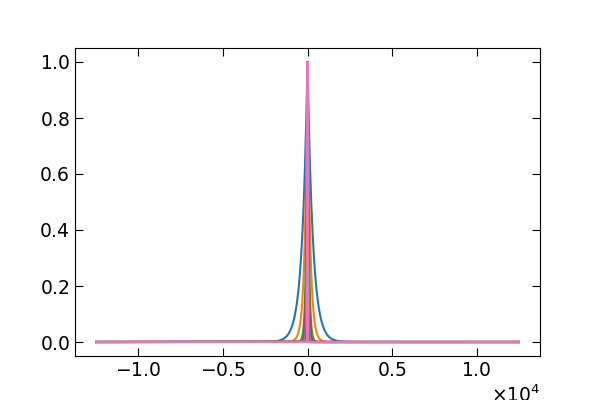

<IPython.core.display.Javascript object>


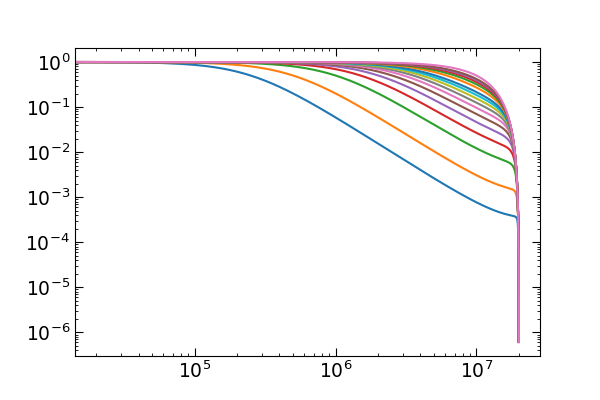

In [830]:
X= weight_array[1:,:]
X2 = np.zeros((np.shape(X)[0]*2-1,np.shape(X)[1]))
for i in range(np.shape(X2)[0]):
    if i%2==0:
        X2[i]=X[i//2]
    else:
        X2[i]= 0.5*(X[i//2]+X[i//2+1])

plt.figure()
plt.plot(X2[:,0],X2[:,1:])

fft = np.fft.rfft(X2[:,1:],axis = 0)
freq= np.fft.rfftfreq(n = np.size(X2[1:,0]),d=dt)
plt.figure()
plt.loglog(freq,np.abs(fft)/np.abs(fft[0,:]))

## Loading weight file

In [3]:
infilename = 'Coefficient_120MHz_tab.txt' ; outfilename= 'Illustrations_ADT_120MHz.txt' ; dt =24.9501
# infilename = 'LBWfeedback_ADT_orig.txt' ; outfilename= 'LBWfeedback_ADT_40MHz.txt'  ; dt = 25



X = np.loadtxt(infilename)
X = X[:,:-1]
t0 = X[np.where(X[:,1]==1.0)[0],0][0]
print(X,t0)
with open(infilename,'r') as infile:
    with open(outfilename,'w') as outfile:
        inlines  = infile.readlines()
        for i,line in enumerate(inlines):
            
            for j,value in enumerate(line.split()):
                if i==0 and j<18:
                    outfile.write("%s \t\t"%value)

                elif j==0:
                    time1 = float(line.split()[0])
                    time2 = time1-t0
                    time3 = (time2+dt/6)//(dt/3) * dt/3
                    print(time1,time2,time3,time3/dt)
                    outfile.write("%-12.5f \t"%time3)

                elif j<18 :
                    outfile.write("%.6f \t"%float(value))
            outfile.write(' \n')
            

[[      -1.    500000.   1000000.  ... 18000000.  20000000.  40000000. ]
 [      49.9        0.         0.  ...        0.         0.         0. ]
 [      58.2        0.         0.  ...        0.         0.         0. ]
 ...
 [    3168.7        0.         0.  ...        0.         0.         0. ]
 [    3177.         0.         0.  ...        0.         0.         0. ]
 [    3185.3        0.         0.  ...        0.         0.         0. ]] 1363.9
49.9 -1314.0 -1314.0386 -52.66666666666667
58.2 -1305.7 -1305.7219 -52.333333333333336
66.5 -1297.4 -1297.4052 -52.0
74.9 -1289.0 -1289.0885 -51.66666666666667
83.2 -1280.7 -1280.7718 -51.333333333333336
91.5 -1272.4 -1272.4551 -51.0
99.8 -1264.1000000000001 -1264.1384 -50.66666666666667
108.1 -1255.8000000000002 -1255.8217 -50.333333333333336
116.4 -1247.5 -1247.5049999999999 -50.0
124.8 -1239.1000000000001 -1239.1883 -49.66666666666667
133.1 -1230.8000000000002 -1230.8716 -49.333333333333336
141.4 -1222.5 -1222.5548999999999 -48.999999999999

<IPython.core.display.Javascript object>


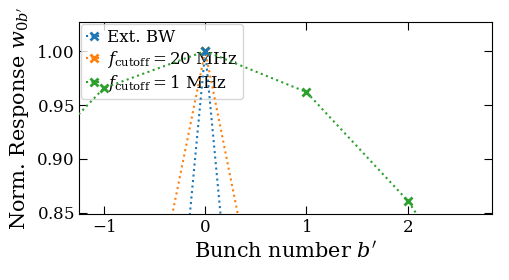

<IPython.core.display.Javascript object>


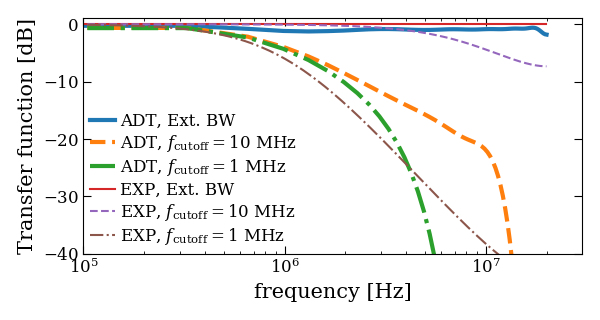

freq 40000000.0
freq 10000000.0
freq 1000000.0
freq 100000000.0
freq 10000000.0
freq 1000000.0


<IPython.core.display.Javascript object>


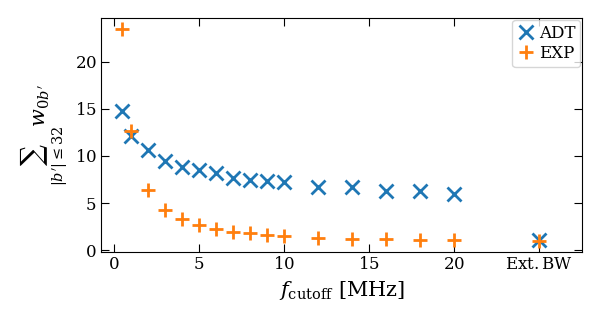

[14.737 12.068 10.668  9.465  8.881  8.541  8.233  7.672  7.474  7.377
  7.246  6.726  6.665  6.274  6.265  5.954  1.106]
[23.489 12.68   6.418  4.322  3.287  2.676  2.277  1.999  1.796  1.643
  1.525  1.358  1.249  1.176  1.126  1.09   1.   ]


In [25]:
flag_savefig=1
flag_time=1
height_fac=0.8
# X = np.loadtxt('LBWfeedback_ADT.txt')
if flag_time:
    Xa = np.loadtxt('LBWfeedback_ADT_40MHz.txt',skiprows=0)     ; dta=25
    Xb = np.loadtxt('LBWfeedback_weight_exp_sym_40MHz.dat')    ;  dtb=25
else:
    Xa = np.loadtxt('Illustrations_ADT_120MHz.txt',skiprows=0)  ; dta=24.9501/3
    Xb = np.loadtxt('LBWfeedback_weight_exp_sym_120MHz.dat')    ; dtb=25/3
X = Xa[0:,:]
X2 = X[1:,:] # [2::3,:]
# X2 = np.zeros((np.shape(X)[0]*2-1,np.shape(X)[1]))
# for i in range(np.shape(X2)[0]):
#     if i%2==0:
#         X2[i]=X[i//2]
#     else:
#         X2[i]= 0.5*(X[i//2]+X[i//2+1])

if 0:
    # All time response
    plt.figure()
    plt.plot(X2[:,0],X2[:,1:])
    plt.xlabel('time [ns]')
    plt.ylabel('Normalized kick amplitude')
    plt.grid(True)
    plt.tight_layout()


    # All frequency response
    dt = dta
    fft = np.fft.rfft(X2[:,1:],axis = 0)
    freq= np.fft.rfftfreq(n = np.size(X2[:,0]),d=dt)
    plt.figure()
    plt.semilogx(freq,20*np.log10(np.abs(fft)**1/np.abs(fft[0,:])**1))
    plt.ylim(-50,0)
    plt.xlim(1e5,4e7)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('ADT response [db]')
    plt.grid(True)
    plt.tight_layout()


# A few responses
flag_complete = 0
if flag_complete:
    plt.figure(figsize=(figwidth,figheight*height_fac))
else:
    plt.figure(figsize=(figwidth*.85,figheight*.7))

for i in [0,1]:
    if i==1 and not flag_complete: continue
    Xi = [Xa,Xb][i]
    X2 = Xi[1:,:]
    for k,j in enumerate([-1,-2,2]):
        label = r'$f_\mathrm{cutoff}=%.*f$ MHz'%(1*(j==1),Xi[0,j]*1e-6)
        if j==-1:
            label='Ext. BW'
            
        if flag_complete:
            plt.plot(X2[:,0]/25,X2[:,j],markers[i*3+k],ls=['-','--'][i],
                     ms=10, label=['ADT, ','EXP, '][i]+label, )
        else:
            plt.plot(X2[:,0]/25,X2[:,j],'x:',
#                      markers[i*3+k],ls=['-','--'][i],
                     ms=6, label=label,zorder=100-k)
bs=np.arange(-32,32.1,1)
#     plt.plot(bs,0*bs,'xr')
plt.xlabel('time [ns]') ; plt.xlim(0,800)
plt.xlabel(r'Bunch number $b^\prime$') ; plt.xlim(-32.5*0,32.5)
plt.ylabel(r"Norm. Response $w_{0b^\prime}$")
# plt.grid(True)
if not flag_complete:
    plt.xlim(-21.5*1,21.5)
    plt.xlim(-16.5*1,16.5)

plt.legend(loc=2,handlelength=1)
plt.tight_layout()
if flag_savefig and flag_time:
    plt.savefig('03_Plots/theory_Weights.eps')

    
# A few frequency responses
plt.figure(figsize=(figwidth,figheight*height_fac))
for i in [0,1]:
    Xi = [Xa,Xb][i]
    X2 = Xi[1:,:]
    dt = [dta,dtb][i]
    for k,j in enumerate([-1,-7,2]):
        label = r'$f_\mathrm{cutoff}=%.0f$ MHz'%(Xi[0,j]*1e-6)
        print('freq',Xi[0,j])
        fft = np.fft.rfft(X2[:,j],axis = 0)
        freq= np.fft.rfftfreq(n = np.size(X2[:,0]),d=dt*1e-9)
    
        if j==-1:
            label='Ext. BW'
        plt.semilogx(freq,20*np.log10(np.abs(fft)**1/np.abs(fft[0])**1),label=['ADT, ','EXP, '][i]+label,
                    ls=['-','--','-.'][k],lw=[3,1.5][i])
#                  ['-x','-+'][i],ms=8, label=['ADT, ','EXP, '][i]+label)
plt.ylim(-40,1)
plt.xlim(1e5,3e7)
plt.xlabel('frequency [Hz]')
plt.ylabel('Transfer function [dB]')
plt.legend(loc=0,handlelength=1.5,framealpha=0.0)
plt.tight_layout()
if flag_savefig and not(flag_time):
    plt.savefig('03_Plots/theory_freqResponse.eps')
    
    
# Sum of responses
fig = plt.figure(figsize=(figwidth,figheight*height_fac))
for i in range(2):
    Xi = [Xa,Xb][i]
    indt0 = np.argmin(np.abs(Xi[1:,0]))
    F = Xi[0,1:]
    F[-1]=2.5e7
    F/=1e6
    
    maxSep=32
    indlo = max(1,indt0- maxSep)
    indup = min(np.size(Xi[1:,0])-1, indt0+maxSep)
    weightsum = np.sum(Xi[indlo:indup+1,1:],axis=0)
    plt.plot(F,weightsum,['x','+'][i],ms=10,label=['ADT','EXP'][i])
    print(weightsum)
plt.xlim(right=2.5e1*1.1)
plt.yscale('linear')
plt.xlabel(r'$f_\mathrm{cutoff}$ $[\mathrm{MHz}]$')
plt.ylabel(r'$\sum_{|b^\prime|\leq 32} w_{0b^\prime}$')
plt.legend(loc=0)
# plt.grid(True)

fig.canvas.draw()
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = '$\\mathrm{Ext. BW}$'
ax.set_xticklabels(labels)
# ax.set_xticks([5e5,1e6,1e7,2e7,1e8])
# ax.set_xticklabels(['$0.5$','$1$','$10$','$20$','$\\mathrm{Ext. BW}$'])
plt.tight_layout()
if flag_savefig and flag_time:
    plt.savefig('03_Plots/theory_sumOfWeights.eps')


# Response functions (Theory)

In [3]:
1/(2*dt)

NameError: name 'dt' is not defined

<IPython.core.display.Javascript object>


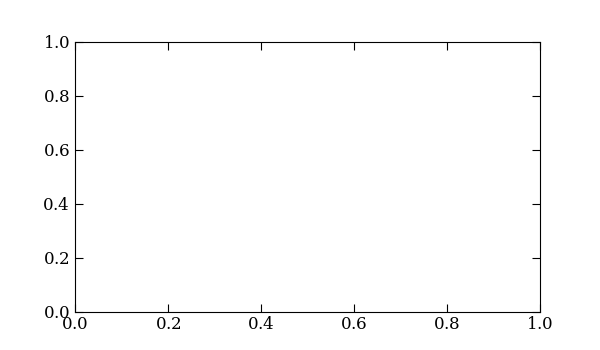

<IPython.core.display.Javascript object>


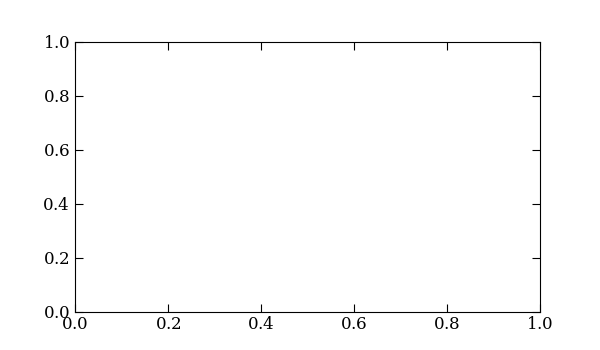

[-5.    -4.975 -4.95  -4.925 -4.9   -4.875 -4.85  -4.825 -4.8   -4.775
 -4.75  -4.725 -4.7   -4.675 -4.65  -4.625 -4.6   -4.575 -4.55  -4.525
 -4.5   -4.475 -4.45  -4.425 -4.4   -4.375 -4.35  -4.325 -4.3   -4.275
 -4.25  -4.225 -4.2   -4.175 -4.15  -4.125 -4.1   -4.075 -4.05  -4.025
 -4.    -3.975 -3.95  -3.925 -3.9   -3.875 -3.85  -3.825 -3.8   -3.775
 -3.75  -3.725 -3.7   -3.675 -3.65  -3.625 -3.6   -3.575 -3.55  -3.525
 -3.5   -3.475 -3.45  -3.425 -3.4   -3.375 -3.35  -3.325 -3.3   -3.275
 -3.25  -3.225 -3.2   -3.175 -3.15  -3.125 -3.1   -3.075 -3.05  -3.025
 -3.    -2.975 -2.95  -2.925 -2.9   -2.875 -2.85  -2.825 -2.8   -2.775
 -2.75  -2.725 -2.7   -2.675 -2.65  -2.625 -2.6   -2.575 -2.55  -2.525
 -2.5   -2.475 -2.45  -2.425 -2.4   -2.375 -2.35  -2.325 -2.3   -2.275
 -2.25  -2.225 -2.2   -2.175 -2.15  -2.125 -2.1   -2.075 -2.05  -2.025
 -2.    -1.975 -1.95  -1.925 -1.9   -1.875 -1.85  -1.825 -1.8   -1.775
 -1.75  -1.725 -1.7   -1.675 -1.65  -1.625 -1.6   -1.575 -1.55  -1.525
 -1.5 

NameError: name 'weight' is not defined

In [4]:
dt = 25e-9

bwidth = 5
t_bunch = np.arange(-bwidth,bwidth+1)*dt
ts = np.linspace(-bwidth*dt,bwidth*dt,401)
freq = np.logspace(3,9,400)
w    = freq*2*np.pi
fco = 1e6
wco = fco*2*np.pi

fig1,ax1=plt.subplots(1,figsize=(figwidth,3.5))
fig2,ax2=plt.subplots(1,figsize=(figwidth,3.5))

bs = ts/dt
print(bs)
for i,mode in enumerate([4,3,0]):
    label="mode %d"%i
    label = ['Sinc','Symmetric','RC'][i]
    ls = ['-','--','-.'][i]
    
    wco = 2*np.pi * [2e7,2e6,1e6,][i]
    
    weights = weight(bs,wco=wco,dt=dt,mode=mode)
    ax1.plot(ts*1e9,weights,ls=ls,label=label)
    
    
    transfer = np.abs(transfer_function(w,wco,dt,mode=mode))
    if np.size(transfer)>1:
        ax2.loglog(freq,transfer/transfer[0],ls=ls,label=label + r', $f_\mathrm{cutoff}=%.0f$ MHz'%(wco/pi2*1e-6))
ax1.plot(t_bunch*1e9,0*t_bunch,'x',label='Bunch')

ax1.set_xlim(-100,100)
ax1.set_xticks(t_bunch*1e9)
ax1.set_xticklabels(np.int32(t_bunch/dt))
ax1.legend(loc=2)
ax1.set_xlabel(r'$t$ [ns]')
ax1.set_xlabel(r'Bunch number')
ax1.set_ylabel(r"Response function $w_{0b\prime}$")
fig1.tight_layout()
fig1.savefig(pltdir+'/responseFunction.eps')


ax2.set_xlabel(r'$f$  $[Hz]$')
ax2.set_ylabel(r'Transfer function')
ax2.legend(loc=0)
ax2.set_ylim(bottom=1e-3)
ax2.set_xlim(right=1e9)
fig2.tight_layout()
fig2.savefig(pltdir+'/transferFunction.eps')

# for iax,ax in enumerate([ax1,ax2]):
#     ax.legend()
#     ax.set_xlabel([r'time [ns]',r'frequency [Hz]'][iax])
#     ax.grid(1,which='major')
#     ax.grid(1,which='minor',ls='--',lw=0.4)
#     fig=[fig1,fig2][iax]
#     fig.tight_layout()
    

<IPython.core.display.Javascript object>


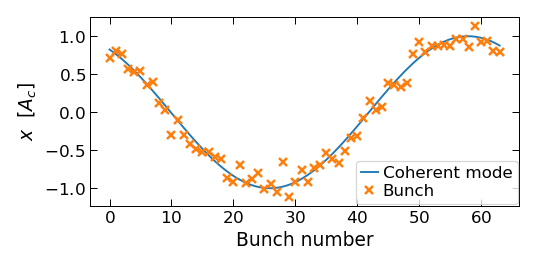

In [122]:
# bunch motion

plt.figure(figsize=(figwidth,3))
As = 1
sig_inc = 0.1
NB=64
bsi=np.linspace(0,NB-1,100)
bs = np.arange(NB)
dt = 25e-9
fc = 1e5
wc = 2*np.pi*fc

M = NB
m = 1

phi0 = np.random.uniform(0,pi2)*0+0.6

Xc = As*np.cos(bsi*pi2 * m/M + phi0) 
xc = As*np.cos(bs*pi2 * m/M + phi0) 
xi = np.random.normal(0,sig_inc,NB)

plt.plot(bsi,Xc,label='Coherent mode')
plt.plot(xc+xi,'x',label='Bunch')

plt.xlabel('Bunch number')
plt.ylabel(r'$x$  $[A_c]$')
plt.legend(loc=0)
plt.tight_layout()
plt.savefig(pltdir+'/beamOscillation.eps')

# plt.ylim(bottom=-As*1.1,top=As*1.1)

# Effective Number of Kicks

## Theory

In [7]:
import sys
sys.path.append('../01_DistributionDiffusion/')
from LebedevHelper import *


In [16]:
mode=3
fcoLF = 1e1
wcoLF = fcoLF*pi2
fco = 1e5
wco = pi2*fco
dt = 25e-9
Nbunches=16*4

bs = np.arange(Nbunches)+1
NtildeLF = np.zeros(Nbunches)
NtildeHF = np.zeros(Nbunches)
NtildeBPM= np.zeros(Nbunches)
for i,ib in enumerate(bs):
    weights = weight(ib-bs,wco=wco,dt=dt,mode=mode)
    ACLF = weight(ib-bs,wco=wcoLF,dt=dt,mode=mode)*0+1
    ACBPM= weights
    NtildeLF[i] = np.sum(weights*ACLF)
    NtildeHF[i] = 1#weights[ib]
    NtildeBPM[i]= np.sum(weights*ACBPM)

# NtildeBPM = NtildeLF**0.5
Ntilde = NtildeLF
print(weights)
print(NtildeLF)
print(NtildeBPM)
print(np.max(NtildeLF))


#########################
### Lebedev reduction ###
dq=1
leb_red = 0.4 #from lebedev_trends
sigma_LF=1e-2   *0
sigma_HF = 1e-3 *1 
sigma_BPM=1e-2  *0
corr = 1

a = 1e-3
b = -0.7*a
g = 1e-2

facLF = np.zeros_like(NtildeLF)
facHF = np.zeros_like(NtildeLF)
facBPM= np.zeros_like(NtildeLF)

for i in range(Nbunches):
    facLF[i] = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeLF[i])))[0]
    facBPM[i]= integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeBPM[i])))[0]    
#     facHF[i] = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g*(NtildeHF[i])))[0]
fac2= facLF
facHF[:]=integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g))[0]    
    
# print(fac2)

print(facLF)
print(facBPM)
print(facHF)

[0.372 0.378 0.384 0.39  0.396 0.402 0.408 0.415 0.421 0.428 0.435 0.442
 0.449 0.456 0.463 0.47  0.478 0.486 0.493 0.501 0.509 0.517 0.525 0.533
 0.542 0.551 0.559 0.568 0.577 0.586 0.595 0.605 0.614 0.624 0.634 0.644
 0.654 0.665 0.675 0.686 0.697 0.708 0.719 0.73  0.742 0.754 0.766 0.778
 0.79  0.803 0.815 0.828 0.841 0.855 0.868 0.882 0.896 0.91  0.924 0.939
 0.954 0.969 0.984 1.   ]
[40.684 41.297 41.888 42.458 43.008 43.537 44.045 44.532 44.999 45.446
 45.872 46.278 46.665 47.031 47.378 47.705 48.012 48.3   48.568 48.817
 49.046 49.256 49.447 49.619 49.771 49.904 50.019 50.114 50.19  50.247
 50.285 50.304 50.304 50.285 50.247 50.19  50.114 50.019 49.904 49.771
 49.619 49.447 49.256 49.046 48.817 48.568 48.3   48.012 47.705 47.378
 47.031 46.665 46.278 45.872 45.446 44.999 44.532 44.045 43.537 43.008
 42.458 41.888 41.297 40.684]
[28.004 28.835 29.631 30.394 31.124 31.822 32.489 33.125 33.73  34.306
 34.853 35.372 35.863 36.326 36.762 37.172 37.555 37.913 38.246 38.553
 38.835 39.

<IPython.core.display.Javascript object>


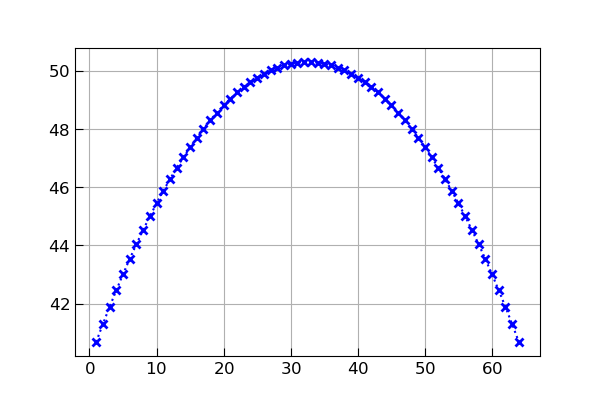

In [17]:
plt.figure()
plt.plot()
plt.plot(bs,NtildeLF,'bx:')
plt.grid(True)

In [9]:
print(sigma_LF,sigma_HF,sigma_BPM)

0.0 0.001 0.0


[8.45  8.485 8.515 8.54  8.562 8.581 8.597 8.611 8.622 8.632 8.641 8.648
 8.654 8.66  8.664 8.668 8.671 8.674 8.677 8.679 8.68  8.682 8.683 8.684
 8.685 8.686 8.686 8.687 8.687 8.687 8.688 8.688 8.688 8.688 8.687 8.687
 8.687 8.686 8.686 8.685 8.684 8.683 8.682 8.68  8.679 8.677 8.674 8.671
 8.668 8.664 8.66  8.654 8.648 8.641 8.632 8.622 8.611 8.597 8.581 8.562
 8.54  8.515 8.485 8.45 ]


<IPython.core.display.Javascript object>


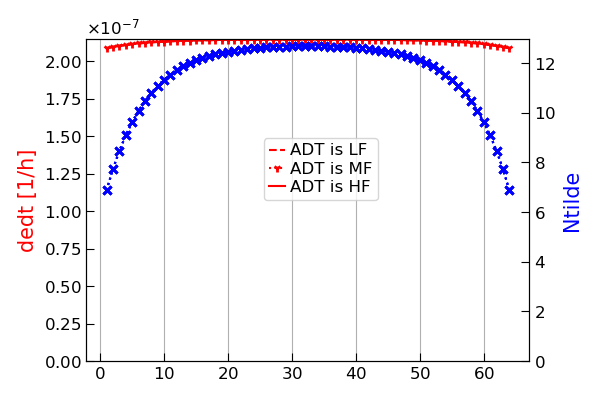

In [10]:
dedt = 0.4*0.5*(sigma_LF**2/(Ntilde)**2 + (sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)*(1-g/2)**2/(1-g/2*(Ntilde-1)))

dedt = 0.5*(fac2*sigma_LF**2 + fac2[0]*(sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)/(1-g/2*(Ntilde-1)))
# dedt = 0.5*(fac2*(sigma_LF**2 + g**2*Ntilde**1*sigma_BPM**2) + fac2[0]*(sigma_HF**2))

LFpart = 1
dedt1 = 0.5*(fac2*sigma_LF**2 + fac2[0]*sigma_HF**2 + (g**2*Ntilde*sigma_BPM**2)*(LFpart*fac2+(1-LFpart)*fac2[0]))
# dedt1 = 0.5*(fac2*sigma_LF**2 + fac2[0]*sigma_HF**2 + (g**2*sigma_BPM**2)*(LFpart*fac2*(Ntilde-1)+(1+1-LFpart)*fac2[0]))
dedt2 = 0.5*(fac2*sigma_LF**2 + fac2[0]*(sigma_HF**2 + g**2*Ntilde*sigma_BPM**2)/(1-g/2*(Ntilde-1)))

# dedt1= 0.5*(facLF * sigma_LF**2 + facHF*sigma_HF**2 + (g**2*NtildeLF*sigma_BPM**2)*(LFpart*facLF+(1-LFpart)*facHF))
dedt = 0.5*(facLF * sigma_LF**2 + facHF*sigma_HF**2 + facBPM*g**2*NtildeLF*sigma_BPM**2)
dedtLF = 0.5 * facLF * sigma_LF **2
dedtHF = 0.5 * facHF * sigma_HF **2 
varIM = sigma_HF**2/(2*g)
dedtIM = 0.5*facHF*varIM*g**2*(NtildeLF-1)

dedtADTisMF = 0.5*(facBPM*g**2*NtildeLF*sigma_BPM**2 )#  /(1-g/2*(NtildeLF-1)))
dedtADTisMF = 0.5*(facBPM*g**2*NtildeLF*sigma_BPM**2  /(1-g/2*(NtildeLF-1)))
dedtADTisLF = 0.5*(facLF*g**2*NtildeLF*sigma_BPM**2)
dedtADTisHF = 0.5*(facHF*g**2*NtildeLF*sigma_BPM**2/(1-g/2*(NtildeLF-1)))
dedtADTisEB = 0.5*facHF*g**2*sigma_BPM**2

dedt = dedtLF + dedtHF + dedtIM

print(dedt * 11245.5*3600)
plt.figure()
plt.gca().xaxis.grid(True)
ax1=plt.gca()
ax=ax1.twinx()

ax.set_ylabel('Ntilde',color='b')
ax.plot(bs,Ntilde,'bx:')
# ax.plot(bs,fac2*40,'orange')
# plt.plot(fac2)


timefac = 11245.5*3600
timefac = 1

# ax1.plot(bs,dedt* 11245.5*3600,'rx:')
ax1.plot(bs,(dedt+dedtADTisLF)* timefac,'r--',label='ADT is LF')
ax1.plot(bs,(dedt+dedtADTisMF)* timefac,'r1:',label='ADT is MF')
ax1.plot(bs,(dedt+dedtADTisHF)* timefac,'r-',label='ADT is HF')
# ax1.fill_between(bs,dedtADTisLF* 11245.5*3600,dedtADTisHF* 11245.5*3600,color='r',alpha=0.2)
ax1.set_ylabel('dedt [1/h]',color='r')

# ax1.set_yscale('log')
if sigma_LF==0 and sigma_HF==0:
    if fco==1e5: ax1.plot(bs,combi_fco1e5_suby* timefac,'kx',label='COMBI')
    if fco==1e6: ax1.plot(bs,combi_fco1e6_suby* timefac,'kx',label='COMBI')
elif sigma_HF==0:
    if fco==1e6: ax1.plot(bs,combi_fco1e6_LF_suby* timefac,'kx',label='COMBI')
# ax1.plot(bs,dedtADTisEB * 11245.5*3600,'r:',label='ADT EB')

ax1.legend(loc=(.4,.5))
for axi in [ax1,ax]:
    axi.set_ylim(bottom=0)
plt.tight_layout()

# ax1.grid(True,axis='x')


In [482]:
combi_fco1e5=np.array([3.62e-07,    3.28e-07,    3.63e-07,    3.84e-07,    3.62e-07,    3.41e-07,    2.74e-07,    3.05e-07,    2.62e-07,    2.46e-07,    1.96e-07,    2.14e-07,    2.80e-07,    3.01e-07,    2.34e-07,    1.96e-07,    2.49e-07,    2.52e-07,    2.25e-07,    2.31e-07,    1.91e-07,    1.61e-07,    1.39e-07,    1.95e-07,    2.09e-07,    2.34e-07,    2.27e-07,    3.15e-07,    2.24e-07,    2.04e-07,    1.99e-07,    2.05e-07,    2.04e-07,    1.92e-07,    2.61e-07,    1.95e-07,    1.32e-07,    2.37e-07,    2.48e-07,    2.27e-07,    2.02e-07,    2.71e-07,    2.54e-07,    2.25e-07,    2.30e-07,    1.86e-07,    2.72e-07,    2.11e-07,    2.39e-07,    2.49e-07,    3.47e-07,    1.92e-07,    2.34e-07,    2.43e-07,    3.79e-07,    3.33e-07,    3.02e-07,    3.53e-07,    2.47e-07,    2.92e-07,    3.04e-07,    3.10e-07,    3.85e-07,    3.18e-07])
combi_fco1e5_suby=np.array([4.41e-07,    3.75e-07,    3.48e-07,    4.30e-07,    4.10e-07,    3.76e-07,    3.10e-07,    3.55e-07,    2.82e-07,    2.76e-07,    2.12e-07,    2.45e-07,    3.17e-07,    3.22e-07,    2.61e-07,    2.15e-07,    2.76e-07,    2.85e-07,    2.57e-07,    2.47e-07,    2.08e-07,    1.99e-07,    1.71e-07,    2.11e-07,    2.41e-07,    2.83e-07,    2.47e-07,    3.50e-07,    2.61e-07,    2.46e-07,    2.37e-07,    2.34e-07,    2.20e-07,    2.22e-07,    2.84e-07,    2.16e-07,    1.66e-07,    2.65e-07,    2.70e-07,    2.69e-07,    2.31e-07,    2.97e-07,    2.71e-07,    2.62e-07,    2.70e-07,    2.22e-07,    2.95e-07,    2.58e-07,    2.62e-07,    2.81e-07,    3.59e-07,    2.21e-07,    2.82e-07,    2.79e-07,    3.93e-07,    3.47e-07,    3.40e-07,    3.69e-07,    2.60e-07,    3.31e-07,    3.42e-07,    3.42e-07,    4.15e-07,    3.79e-07])

combi_fco1e6_suby=np.array([ 6.56e-07,    7.86e-07,    6.27e-07,    7.63e-07,    7.05e-07,    7.13e-07,    6.18e-07,    6.61e-07,    6.53e-07,    6.62e-07,    6.66e-07,    6.43e-07,    8.04e-07,    6.34e-07,    6.21e-07,    6.79e-07,    7.35e-07,    5.99e-07,    6.00e-07,    6.81e-07,    6.45e-07,    6.71e-07,    6.39e-07,    6.12e-07,    5.74e-07,    8.46e-07,    7.99e-07,    8.47e-07,    7.52e-07,    7.32e-07,    7.41e-07,    6.09e-07,    7.05e-07,    6.50e-07,    5.94e-07,    5.29e-07,    7.33e-07,    6.34e-07,    6.42e-07,    4.70e-07,    6.34e-07,    6.18e-07,    6.51e-07,    6.94e-07,    6.51e-07,    6.00e-07,    7.27e-07,    5.76e-07,    8.35e-07,    7.72e-07,    7.46e-07,    7.95e-07,    7.27e-07,    8.55e-07,    6.12e-07,    6.62e-07,    6.82e-07,    5.56e-07,    5.66e-07,    7.12e-07,    6.01e-07,    6.32e-07,    6.65e-07,    8.60e-07])
combi_fco1e6_LF_suby=np.array([  2.40e-05,    1.28e-05,    7.82e-06,    5.47e-06,    4.75e-06,    4.43e-06,    3.67e-06,    3.63e-06,    3.42e-06,    3.30e-06,    3.57e-06,    2.86e-06,    2.80e-06,    3.02e-06,    2.99e-06,    2.81e-06,    3.10e-06,    2.77e-06,    2.60e-06,    2.69e-06,    2.85e-06,    2.74e-06,    2.94e-06,    2.89e-06,    2.59e-06,    3.08e-06,    3.00e-06,    2.94e-06,    2.83e-06,    2.91e-06,    2.81e-06,    2.96e-06,    3.01e-06,    2.86e-06,    2.98e-06,    3.04e-06,    3.14e-06,    3.23e-06,    3.15e-06,    2.82e-06,    3.07e-06,    3.14e-06,    3.02e-06,    2.85e-06,    2.73e-06,    2.85e-06,    2.80e-06,    2.85e-06,    2.77e-06,    3.02e-06,    2.58e-06,    3.21e-06,    3.03e-06,    2.93e-06,    2.92e-06,    2.98e-06,    3.01e-06,    3.18e-06,    2.64e-06,    2.95e-06,    3.17e-06,    2.76e-06,    3.25e-06,    3.04e-06])

## Weight from file

122 122 48 73
0.0 [  10    9    8    7    6    5    4    3    2    1    0   -1   -2   -3
   -4   -5   -6   -7   -8   -9  -10  -11  -12  -13  -14  -15  -16  -17
  -18  -19  -20  -21  -22  -23  -24  -25  -26  -27  -28  -29  -30  -31
  -32  -33  -34  -35  -36  -37  -38  -39  -40  -41  -42  -43  -44  -45
  -46  -47  -48  -49  -50  -51  -52  -53  -54  -55  -56  -57  -58  -59
  -60  -61  -62  -63  -64  -65  -66  -67  -68  -69  -70  -71  -72  -73
  -74  -75  -76  -77  -78  -79  -80  -81  -82  -83  -84  -85  -86  -87
  -88  -89  -90  -91  -92  -93  -94  -95  -96  -97  -98  -99 -100 -101
 -102 -103 -104 -105 -106 -107 -108 -109 -110 -111 -112 -113 -114 -115
 -116 -117] -48 73
[ 10   9   8   7   6   5   4   3   2   1   0  -1  -2  -3  -4  -5  -6  -7
  -8  -9 -10 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 -21 -22 -23 -24 -25
 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35 -36 -37 -38 -39 -40 -41 -42 -43
 -44 -45 -46 -47 -48] -48 73
[58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35
 34

<IPython.core.display.Javascript object>


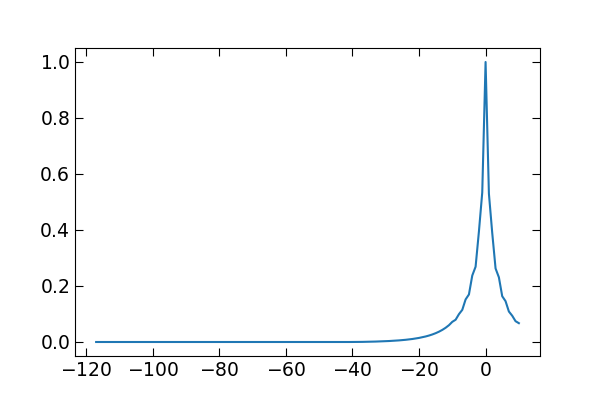

In [296]:
fcutoff =3e7
b,wco,dt,mode = 10 - np.arange(128),fcutoff*2*np.pi,25e-9,11


Xa = np.loadtxt('LBWfeedback_ADT_40MHz.txt',skiprows=1)
freq = Xa[0,1:]
indf = np.argmin(np.abs(freq-wco/pi2))
weights = Xa[1:,1+indf]

ts = Xa[1:,0]
indt0= np.argmin(np.abs(ts))
mint = -indt0
maxt = np.size(ts)-indt0-1
if mode ==10:
    mint = max(mint,-32)
    maxt = min(maxt,32)

weightsb = np.zeros_like(b,dtype=np.float64)
indb  = np.logical_and(b>=mint,b<=maxt)

    
print(np.size(ts),np.size(weights),indt0,maxt)
print(ts[indt0], b,mint,maxt)
print(b[indb],mint,maxt)
print(indt0+b[indb])
print(b[indb])
print(weights[indt0+b[indb]])

    
weightsb[indb]=weights[indt0+b[indb]]


# print(ts[indt0], b,mint,maxt)
# print(b[indb],mint,maxt)
# print(indt0+b[indb],weights[indt0+b[indb]])
plt.figure()
plt.plot(b,weightsb)



# FIR filter


In [9]:
# Coefficients from https://accelconf.web.cern.ch/accelconf/e08/papers/thpc122.pdf 
FIR_filter = [0.0096,  0.0192,  0.0481,  0.0673,  0.0769,  0.1154,
                0.1442,  0.1442,  0.2115,  0.2403,  0.2596,  0.3077,
                0.3558,  0.3846,  0.4519,  0.5192,  0.6346,  0.75,
                0.9519,  1.2019,  1.6346,  2.6346,  7.0192, -5.1923,
                -1.4135, -0.6827, -0.3942, -0.2308, -0.1442, -0.096,
                -0.0192, -0.0096]
FIR_filter = np.array(FIR_filter)
FIR_filter = FIR_filter/sum(FIR_filter)
FIR_filter = np.roll(FIR_filter,len(FIR_filter)//2)
print(FIR_filter)

[ 0.063  0.075  0.095  0.12   0.163  0.263  0.702 -0.519 -0.141 -0.068
 -0.039 -0.023 -0.014 -0.01  -0.002 -0.001  0.001  0.002  0.005  0.007
  0.008  0.012  0.014  0.014  0.021  0.024  0.026  0.031  0.036  0.038
  0.045  0.052]


<IPython.core.display.Javascript object>


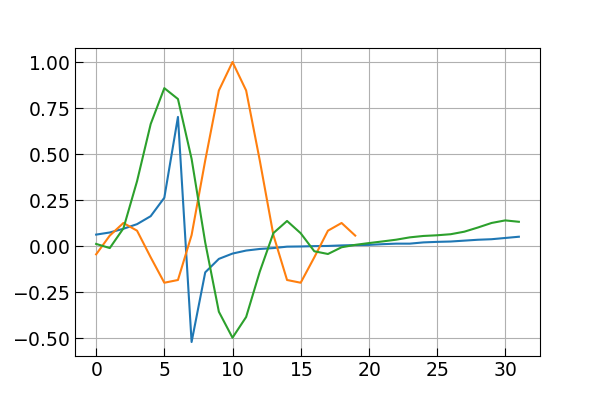

In [10]:
dt = 1/80e6
fco=4e6
wco=pi2*fco
ts = np.arange(20)*dt

lowpass = np.exp(-ts*wco)
lowpass = np.sinc((ts-dt*10)*wco)

combined = np.convolve(FIR_filter,lowpass,mode='same')

plt.figure()
plt.plot(FIR_filter)
plt.plot(lowpass)
plt.plot(combined)
plt.grid(True)

In [11]:
# How many bunches are counted
np.log(1000)/(pi2*25e-9*1e5)

439.76135932765663

In [13]:
np.exp(-2*np.pi*25e-9*1e5*63)

0.37172472474445467

# Is feedback error LF or HF noise?

In [140]:
fco = 1e6
wco = pi2*fco
dt = 25e-9

Nb = 128*32
mux=1
sigx=0.1
sigbpm=0.1

xbi = np.random.randn(Nb)*sigx 
dbpm= np.random.randn(Nb)*sigbpm
bs  = np.arange(Nb)
kicks = np.zeros(Nb)

for i in range(Nb):
    kicks[i] = np.sum(weight(bs[i]-bs,wco=wco,dt=dt,mode=2)*dbpm)

<IPython.core.display.Javascript object>


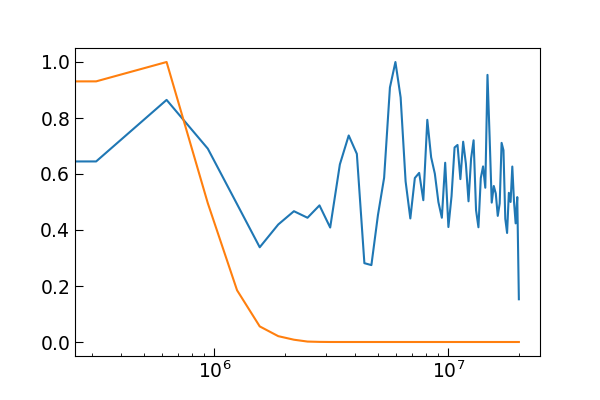

In [141]:
from scipy import signal
plt.figure()
# plt.plot(dbpm)
# plt.plot(kicks)
for xi in [dbpm,kicks]:
#     xf= np.fft.rfft(xi,axis=0,norm='ortho')#/Nx#,norm='ortho')
#     ff= np.fft.rfftfreq(Nb,d=dt)
    ff,xf=signal.welch(xi,fs=1/dt,return_onesided=True,nperseg=128*1)
    plt.semilogx(ff,np.abs(xf/np.max(xf))**2)

# COMBI results

In [3]:
sys.path.append('/home/sfuruset/hdd/01_Python/02_IPython/01_DistributionDiffusion/')
sys.path.append('/home/sfuruset/hdd/05_Combi_related/05_COMBIp/src/python')
from LebedevHelper import *
from postprocess import *
from parseInput import *
from scipy import constants as cst
folder1 = '/home/sfuruset/hdd/05_Combi_related//01_output/Multibunch/'
import matplotlib.ticker as ticker

def dir_name2(Nb,npart,nturn,gain,gmode,gdelay,octuA,octuB,softgauss_Scale,chroma,Qs,
              sep,fmax_LF,sigma_LF,sigma_HF,sigma_BPM,f_co):
    strQp = '%d'%chroma
    if abs(chroma)%1 >0 :# and abs(chroma) >0:
        strQp = '%.2f'%chroma
    strDet = ''
    if octuA!=0 or octuB!=0 or 1:
        strDet+= '_OPa%s_OPb%s'%(sci(octuA,1),sci(octuB,1))
    if softgauss_Scale!=0 or 1:
        strDet+= '_BBS%s'%(sci(softgauss_Scale,2))
    return 'nb%d_Np%s_T%s_g%s_mode%d-%d%s_Qp%s_dx%s_HF%s_BPM%s_LF%s-fmax%s_fco%s'%(
            Nb,sci(npart,0),sci(nturn,0),sci(gain,1),gmode,gdelay,strDet,strQp,
            sci(sep,1),sci(sigma_HF,1),sci(sigma_BPM,1),sci(sigma_LF,1),sci([fmax_LF,0][sigma_LF==0],3),sci(f_co,1))

def weight(b,wco,dt,mode):
    if mode==1:
        ans = np.array(np.exp(-wco*dt*b))
        ans[b<0] = 0
        return ans
#         return np.exp(-wco*dt*np.abs(b))*(1+1*(b==0))/2
    elif mode==2:
        return np.exp(-np.abs(b)*wco*dt)
    elif mode in [10,11]:
        # ADT weight from file
        Xa = np.loadtxt('/home/sfuruset/hdd/05_Combi_related/05_COMBIp/wakes/LBWfeedback_ADT_40MHz.txt',skiprows=1)
        freq = Xa[0,1:]
        indf = np.argmin(np.abs(freq-wco/pi2))
        weights = Xa[1:,1+indf]

        ts = Xa[1:,0]
        indt0= np.argmin(np.abs(ts))
        mint = -indt0
        maxt = np.size(ts)-indt0-1
        if mode ==10:
            mint = max(mint,-32)
            maxt = min(maxt,32)

        weightsb = np.zeros_like(b,dtype=np.float64)
        indb  = np.logical_and(b>=mint,b<=maxt)
#         print('TEST')
#         print(indb)
#         print(indt0+b[indb])
#         print(indt0,b)
        weightsb[indb]=weights[indt0+b[indb]]
        # print(b[indb])

        return weightsb

def bb_alex(bb_param,g):
    s0=0.645
    return (1-s0)/2/(1+g/(2*np.pi*bb_param))**2
    
    
def getNtildeLL(bs,mode,fco,dt,fcoh = 0,a=0,b=0,bb_param=0,g=0):
    Ntilde = np.zeros(np.size(bs))
    facLF  = np.zeros(np.size(bs))
    print('getNtildeLL',a,b,bb_param,g)
    for i,ib in enumerate(bs):
        weights = weight(ib-bs,wco=pi2*fco,dt=dt,mode=mode)*np.cos(pi2*fcoh*(ib-bs)*dt)
        Ntilde[i] = np.sum(weights)
        if a!=0 and bb_param==0:
            facLF[i] = integrate.nquad(int_octu_leb, [[0,20], [0,20]],args=(a,b,g*(Ntilde[i])))[0]
        elif a==0 and bb_param!=0:
            facLF[i] = bb_alex(bb_param,g*(Ntilde[i]))
        else:
            facLF[i]=np.nan
    
    
    if a!=0 and bb_param==0:
        facHF = integrate.nquad(int_octu_leb, [[0,20], [0,20]],args=(a,b,g))[0]
    elif a==0 and bb_param!=0:
        facHF = bb_alex(bb_param,g)
    else:
        facHF=np.nan
    
    return Ntilde,facLF,facHF

def getNtildeLL2(bs,mode,fco,dt,frev=1e4,fmax=1e4,Q0=0.31,a=0,b=0,bb_param=0,g=0):
    
    facLF  = np.zeros(np.size(bs))
    Nfrev= int(fmax/frev+0.5)
    
    # Make list of reasonable values
    ib = bs[-1]//2
    NtildeMax = np.sum(weight(ib-bs,wco=pi2*fco,dt=dt,mode=mode)*1)
    NtildeMin1 = np.sum(weight(ib-bs,wco=pi2*fco,dt=dt,mode=mode)*np.cos(pi2*fmax*(ib-bs)*dt))
    ib=0
    NtildeMin2 = np.sum(weight(ib-bs,wco=pi2*fco,dt=dt,mode=mode)*np.cos(pi2*fmax*(ib-bs)*dt))
    NtildeMin = min(NtildeMin1,NtildeMin2)
    if NtildeMin<NtildeMax:
        Ns = np.concatenate((np.linspace(0,NtildeMin,5,endpoint=False), np.linspace(NtildeMin,NtildeMax*1.1,100)))
    else:
        Ns = np.linspace(0,NtildeMin*1.1,100)
    facTemp = np.zeros_like(Ns)
    for i,N in enumerate(Ns):
        if N<=0:
            facTemp[i]=1
        elif a!=0 and bb_param==0:
            facTemp[i] = integrate.nquad(int_octu_leb, [[0,20], [0,20]],args=(a,b,g*N))[0]
        elif a==0 and bb_param!=0:
            facTemp[i] = bb_alex(bb_param,g*N)
    facInterp =  interpolate.interp1d(Ns,facTemp,kind='quadratic',bounds_error=False,fill_value=(facTemp[0],facTemp[-1]))
        
    print('getNtildeLL2',a,b,bb_param,g,'%.2e < Ntilde < %.2e'%(NtildeMin,NtildeMax))
#     plt.figure()
#     plt.plot(Ns,facTemp,'rx-')
#     Ntest = np.linspace(0,NtildeMax*2,500)
#     plt.plot(Ntest,facInterp(Ntest))
    
    for j in range(Nfrev):
        for k in range(2):
            fcoh = [j+Q0,j+1-Q0][k]*frev
            for i,ib in enumerate(bs):
                weights = weight(ib-bs,wco=pi2*fco,dt=dt,mode=mode)*np.cos(pi2*fcoh*(ib-bs)*dt)
                Ntilde = np.sum(weights)
#                 if Ntilde<Ns[0] or Ntilde>Ns[-1]:
#                     print('ERROR Ntilde=%.2e is not between (%.2e,%.2e)'%(Ntilde,Ns[0],Ns[-1]))
                if a!=0 and bb_param==0:
                    facLF[i]+= facInterp(Ntilde)/(2*Nfrev)
                elif a==0 and bb_param!=0:
                    facLF[i]+= facInterp(Ntilde)/(2*Nfrev)
                else:
                    facLF[i]=np.nan
    
    
    if a!=0 and bb_param==0:
        facHF = integrate.nquad(int_octu_leb, [[0,20], [0,20]],args=(a,b,g))[0]
    elif a==0 and bb_param!=0:
        facHF = bb_alex(bb_param,g)
    else:
        facHF=np.nan
    
    return Ntilde,facLF,facHF

/home/sfuruset/hdd/05_Combi_related/05_COMBIp/src/python/postprocess.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')  # To plot on cluster


In [4]:
# Calculate max sum(weights) for all modes
if 0:
    bunches = 300
    ib = bunches//2
    bs = np.arange(bunches)

    fcos = [5e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,10e6,12e6,14e6,16e6,18e6,20e6,1e8,1e8,1e8]
    weightsum = np.zeros_like(fcos)
    mode=11
    for i,fco in enumerate(fcos):
        weightsum[i] = np.sum(weight(ib-bs,wco=pi2*fco,dt=25e-9,mode=mode)*1) #np.cos(pi2*fcoh*(ib-bs)*dt)


    print(weightsum)
    np.savetxt('01_Output/maxNtilde_mode%d.txt'%mode,[fcos,weightsum])

In [27]:
flag_recalculateLL = 0
flag_theory = 1
flag_combi = 1

npart =1e6
nturn=1e5


nb = 128
imode =1
gmode = [1,2,10,11][imode]
modename = ['One-sided RC','Symmetric EXP','Digital ADT', 'Analog ADT'][imode]
gdelay = 4
g= 0.01
fco=1e6


sep=0
fmax_LF =1/89100e-9 *1
sig_LF = [0 , 1e-3][ 1 ]
sig_HF = [0 , 1e-3][ 0 ]
sig_BPM= [0 , 5e-2][ 0 ]  /1

flag_HLLHC = 0
softgauss_Scale0=[1.1790,3.283][flag_HLLHC]
bb_param0 = 7.9193e-03*softgauss_Scale0
a0=1.09e-3      
softgauss_Scale = softgauss_Scale0 * 0
a = a0                             * 1
b=-0.7*a
bb_param = bb_param0*softgauss_Scale/softgauss_Scale0
chroma =  0
Qs = [0.0019 , 0.0021][flag_HLLHC]


dt=25e-9 *1
frev=1/89100e-9
frev_LHC=11245.5
turns_per_dt = 3600*frev  ; eps_rel=1 ; vmax=20    ; addname='_perh'
turns_per_dt = 1 ; eps_rel=sig_LF**2/2 ; vmax=1     ; addname='_perMax'

# turns_per_dt = 1           ; vmax=5e-6  ; addname='_perT'
fcoh= [frev*(1-0.31),1e7][sig_HF>0]
fcoh= fmax_LF-0.31*frev


# calculate Qs
intensity = 1.0e11
energy = 6.5E3   # 2018 6.5e3 , HL-LHC 7e3
emittance = 2E-6
sigs = 1.10E-9/4.0*cst.c
sigs = 1.05E-9/4.0*cst.c 
momentumCompaction = 3.483575072011584e-04
voltage = 12.0E6   # 2018: 12e6, HL-LHC 16e6
#LHC design
# energy = 7e3 ; emittance=3.75e-6 ; momentumCompaction = 3.225e-4*1. ; voltage = 16e6  ; sigs=0.0755
# HL-LHC design
# energy = 7e3 ; emittance=2.5e-6    ; momentumCompaction = 3.483575072011584e-04 ; voltage = 16e6 ; sigs=0.0755
# LHC 2018 
energy = 6.5e3 ; emittance=2.e-6    ; momentumCompaction = 3.483575072011584e-04 ; voltage = 12e6 ; sigs=0.08

gamma = energy*1E3/cst.value('proton mass energy equivalent in MeV')
beta=np.sqrt(1.-1./(gamma**2))
eta = momentumCompaction-1.0/gamma**2
h = 35640
p0=cst.m_p*beta*gamma*cst.c
qs=np.sqrt(cst.e*voltage*eta*h/(2*np.pi*beta*cst.c*p0))
averageRadius = 26658.8832/(2*np.pi)
sigp = qs*sigs/(averageRadius*eta)
print('Qs (machine)=',qs)
print('sigp=%.6e'%sigp)
print('bunch length',sigs , .08/cst.c*4)

Qs (machine)= 0.0019099080571338284
sigp=1.033811e-04
bunch length 0.08 1.0674051046340867e-09


## x= bunch-number

<IPython.core.display.Javascript object>


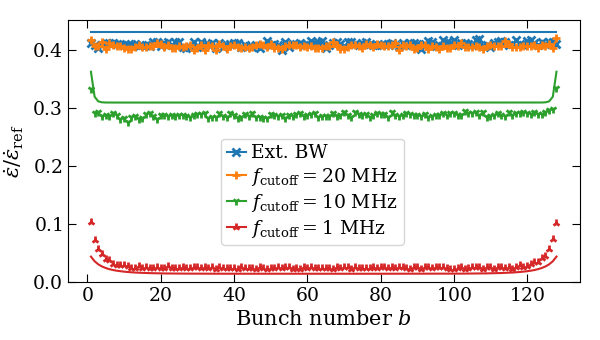

0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8
Number of bunches: 128 0
1 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco2.0e7
Number of bunches: 128 0
2 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e7
Number of bunches: 128 0
3 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e6
Number of bunches: 128 0
4 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e5
Number of bunches: 0 0


In [29]:
### x = bunch number
plt.figure(figsize = (figwidth,figheight*0.85))
# plt.figure(figsize = (figwidth*.85,figheight))

fcos = [1e5,1e6,1e7,2e7,1e8]
# fcos = [1e5,1e7,5e5,2e7,1e8]

study =1

flag_Theory = True
for i in range(5):
    if study==1:
        fco=fcos[::-1][i]
        label = r'$f_\mathrm{cutoff}=$%s MHz'%(short_float(fco/1e6))
        if fco>=1e8:
            label='Ext. BW'
            
        if gmode==10 and fco==1e7: continue
            
        studyname = ['ioct','bb'][a==0]
        
    # Get correct file
    folder2 = fname = dir_name2(nb,npart,nturn,g,gmode,gdelay,a,b,softgauss_Scale,chroma,Qs,
          sep,fmax_LF,sig_LF,sig_HF,sig_BPM,fco)
    print(i,fname)
    fname = folder1 + fname
    pp_B1,pp_B2 = postprocess_gather(fname)
    if np.size(pp_B1)+np.size(pp_B2)==0: continue
    bunches = np.arange(1,nb+1,dtype=np.int32)
    
    

    # Plot theory
    ls = ''
    if sig_LF>0 and sig_BPM==0  and 1  :# or flag_EBW :
        theoryfname = fname+'/theory_dedt_LL2.txt'
        theoryfname_loc='01_Output/'+folder2+'-theory_dedt_LL2.txt'
        if os.path.exists(theoryfname) and  not flag_recalculateLL:
            LL  = np.loadtxt(theoryfname)
        elif os.path.exists(theoryfname_loc) and  not flag_recalculateLL:
            LL  = np.loadtxt(theoryfname_loc)
            if os.path.exists(fname):
                np.savetxt(theoryfname,LL)
        else:
            #Ntilde,LL,_ = getNtildeLL(bunches,gmode,fco,dt,fcoh = fcoh,a=a,b=b,bb_param=bb_param,g=g)
            Ntilde,LL,_ = getNtildeLL2(bunches,gmode,fco,dt,frev=frev,fmax=fmax_LF,a=a,b=b,bb_param=bb_param,g=g)
            if os.path.exists(fname):
                np.savetxt(theoryfname,LL)
            else:
                np.savetxt(theoryfname_loc,LL)
            print(LL)
        dedtLF = 0.5*sig_LF**2 /eps_rel             + 0*LL
        dedtHF = 0.5*(g**2*sig_BPM**2 + sig_HF**2)  + 0*LL
        ls= '-'
        plt.plot(bunches, LL*(dedtLF + dedtHF) ,ls=ls ,c=colors[i])
        
#         print(dedtLF)
        
#         if flag_Theory :
#             flag_Theory = False
#             line,=plt.plot(np.nan,np.nan,'k-',label='Theory')
#             if sig_HF>0:
#                 plt.plot(bunches,dedtLF + dedtHF,'k--',label=r'Theory, $g=0$')
#             print(fco,'lebedev reduction:\n',LL)
            
    # Plot simulation
    bunches = np.arange(1,nb+1)
    dedt = (pp_B1[1]-1*pp_B1[3]) / eps_rel 
    plt.plot(bunches,dedt,markers[1+i],c=colors[i])
    plt.plot(np.nan,np.nan,marker = markers[1+i],ls=ls,c=colors[i], label = label)

    
plt.xlabel(r'Bunch number $b$')
plt.ylabel(r'$\dot{\epsilon}/\dot{\epsilon}_\mathrm{ref}$')
plt.legend(loc=[0,(0.3,0.07*gmode)][1])
plt.ylim(bottom=0)
plt.tight_layout()

plt.savefig('03_Plots/allbunches_%s_gmode%d-%d.eps'%(studyname,gmode,gdelay))

# plt.title(modename)
plt.tight_layout()

## x= f_cutoff

<IPython.core.display.Javascript object>


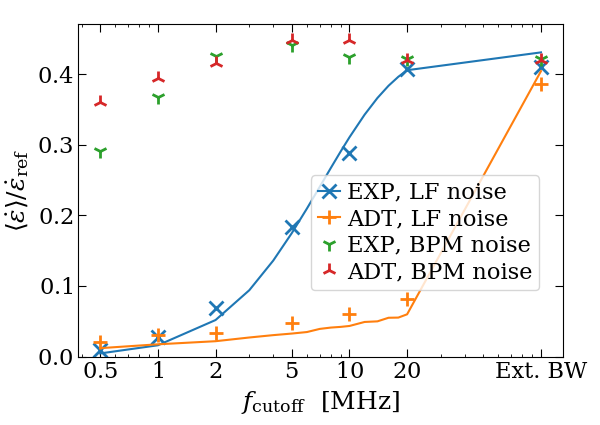

0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco5.0e5
Number of bunches: 128 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e6
Number of bunches: 128 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco2.0e6
Number of bunches: 128 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco3.0e6
Number of bunches: 0 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco4.0e6
Number of bunches: 0 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco5.0e6
Number of bunches: 128 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco6.0e6
Number of bunches: 0 0
0 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BP

In [102]:
### x = fco
plt.figure(figsize=(figwidth,figheight*.85))

fcos = np.array([5e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,12e6,14e6,16e6,18e6,2e7,1e8])
# fcos = np.array([5e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,12e6,2e7,1e8])

study =3


for i in range(7):
    
    if study==1:
        # Octupole vs Beam-beam
        if i>4: continue
        i = (i+2)%5
        a = a0 * [1,1,0,0,0][i]
        b= -0.7*a
        bb_param = bb_param0 * [0,0,1,1,1][i]
        softgauss_Scale = softgauss_Scale0*[0,0,1,1,1][i]
        chroma = 7.5 * [0,2,0,1,2][i]
        label = [r'Octupole, $Q^\prime=0$',r'Octupole, $Q^\prime=15$',
                 r'Beam-beam, $Q^\prime=0$',r'Beam-beam, $Q^\prime=7.5$',r'Beam-beam, $Q^\prime=15$'][i]
        studyname = 'octuVSbb'
        
    if study ==2:
        # Different noise thresholds
        if i>5 or i==2: continue
        fmax_LF = [1,89,178,267,446,891][i] * frev
        fcoh = fmax_LF -0.31*frev
        label = r'$f_\mathrm{max}\approx$%s MHz'%sci_not([1.12233e4,1e6,2e6,3e6,5e6,1e7][i]/1e6,1)
        label = r'$f_\mathrm{max}=%.0f$ MHz'%(fmax_LF/1e6)
        if i==0:
            label = r'$f_\mathrm{max}=11$ kHz'
        studyname = 'fmax_LF'
        
    if study==3:
        # BPM
        if i>3: continue
        fmax_LF = 1/89100E-9*[1,1,0,0][i]
        sig_LF = 1e-3 * [1,1,0,0][i]
        sig_BPM = 5e-2* [0,0,1,1][i]
        gmode = [2,10,2,10][i]
        eps_rel  = (sig_LF**2 + (g*sig_BPM)**2)/2
        label = ['EXP, LF noise','ADT, LF noise', 'EXP, BPM noise', 'ADT, BPM noise'][i]
        modename=''
        studyname = 'BPM'
    
    dedt_combi = np.zeros_like(fcos)*np.nan
    dedt_theory= np.zeros_like(fcos)*np.nan
    
    for j ,fco in enumerate(fcos):
        folder2 = dir_name2(nb,npart,nturn,g,gmode,gdelay,a,b,softgauss_Scale,chroma,Qs,
                  sep,fmax_LF,sig_LF,sig_HF,sig_BPM,fco)
        print(i,folder2)
        fname = folder1 + folder2
        
        # Get COMBI results
        if flag_combi:
            
            pp_B1,pp_B2 = postprocess_gather(fname)
            if np.size(pp_B1)+np.size(pp_B2)>0:
                dedt_combi[j] = np.mean((pp_B1[1]-1*pp_B1[3])) / eps_rel 
    
    

        # Get theory
        if sig_LF>0 and sig_BPM==0  and chroma==0 and flag_theory or 0:
            theoryfname = fname+'/theory_dedt_LL2.txt'
            theoryfname_loc='01_Output/'+folder2+'-theory_dedt_LL2.txt'
            if os.path.exists(theoryfname) and  not flag_recalculateLL:
                LL  = np.loadtxt(theoryfname)
            elif os.path.exists(theoryfname_loc) and  not flag_recalculateLL:
                LL  = np.loadtxt(theoryfname_loc)
                if os.path.exists(fname):
                    np.savetxt(theoryfname,LL)
            else:
                bunches=np.arange(nb)
                #Ntilde,LL,_ = getNtildeLL(bunches,gmode,fco,dt,fcoh = fcoh,a=a,b=b,bb_param=bb_param,g=g)
                Ntilde,LL,_ = getNtildeLL2(bunches,gmode,fco,dt,frev=frev,fmax=fmax_LF,a=a,b=b,bb_param=bb_param,g=g)
                if os.path.exists(fname):
                    np.savetxt(theoryfname,LL)
                else:
                    np.savetxt(theoryfname_loc,LL)
                print(LL)
            
            dedt_theory[j] = np.mean(LL)*0.5*sig_LF**2 /eps_rel
        
    
    for k in range(2):
        dedt = [dedt_combi,dedt_theory][k]
        ind  = np.isfinite(dedt)
        c= colors[i]
        m = markers[1+i]
        if np.any(ind):
            ls = ['','-'][k]
            marker = [m,''][k]
            print(label)
            plt.plot(fcos[ind],dedt[ind],ls+marker,ms=10,c=c)
    plt.plot(np.nan,np.nan,ls=ls,marker=m,c=c,ms=10,label=[None,label][k])
    plt.xscale('log')

fig.canvas.draw()
ax = plt.gca()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[-1] = '$\\mathrm{Ext. BW}$'
# ax.set_xticklabels(labels)
ax.set_xticks([5e5,1e6,2e6,5e6,1e7,2e7,1e8])
ax.set_xticklabels(['$0.5$','$1$','$2$','$5$','$10$','$20$','Ext. BW'])
# plt.ylim(top=0.65)

plt.ylabel(r'$\langle\dot{\epsilon}\rangle/\dot{\epsilon}_\mathrm{ref}$')
plt.xlabel(r'$f_\mathrm{cutoff}$  [MHz]')
plt.ylim(bottom=0)
if study ==2:
    plt.ylim(top=1)
plt.legend(loc=(.48,.2),
#            fontsize=ticksize*1,framealpha=0
          )
plt.tight_layout()

plt.savefig('03_Plots/scanfco_%s_gmode%d-%d.eps'%(studyname,gmode,gdelay))

plt.title(modename)
plt.tight_layout()

In [33]:
xi = 0.022
rmsdq=0.168*xi
rmsdmu = rmsdq * 2* np.pi
gl=1e-3 * 6

leb = (1-(gl/2))**2*rmsdmu**2 /  ( gl**2/4 + (1-gl/2)*rmsdmu**2 )
print(leb)
alex = (1+gl/(2*np.pi*xi))**(-2)
print(alex)

0.9805861877685307
0.9185301771602871


## y= gain, x=f_cutoff

<IPython.core.display.Javascript object>


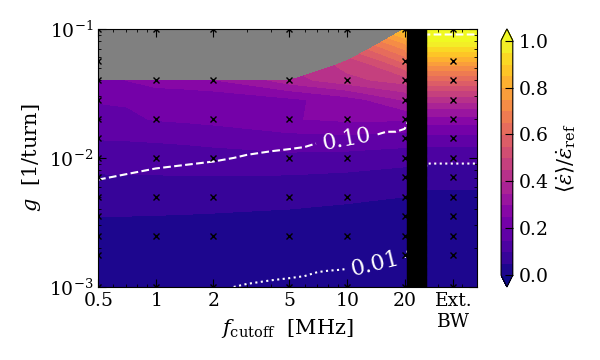

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:110: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Difference B1 vs B2 relative 0.009576431117756254
fco [5.000e+05 7.071e+05 1.000e+06 1.414e+06 2.000e+06 5.000e+06 1.000e+07
 2.000e+07 2.600e+07 3.600e+07 1.000e+08]
gain [0.001, 0.0017677669529663686, 0.0025, 0.003535533905932738, 0.005, 0.007071067811865476, 0.01, 0.014142135623730952, 0.02, 0.028284271247461905, 0.04, 0.05656854249492381, 0.1]
[[0.01  0.01  0.009 0.009 0.008 0.007 0.005 0.004 0.002 0.002 0.002]
 [0.022 0.021 0.021 0.02  0.02  0.017 0.014 0.011 0.007 0.007 0.007]
 [0.034 0.033 0.032 0.031 0.03  0.027 0.022 0.018 0.012 0.012 0.012]
 [0.05  0.05  0.049 0.048 0.047 0.043 0.037 0.031 0.023 0.023 0.023]
 [0.071 0.071 0.071 0.07  0.07  0.065 0.058 0.05  0.04  0.04  0.04 ]
 [0.095 0.096 0.096 0.097 0.098 0.095 0.09  0.079 0.069 0.069 0.069]
 [0.125 0.128 0.132 0.134 0.137 0.138 0.134 0.122 0.114 0.114 0.114]
 [0.152 0.154 0.156 0.158 0.163 0.183 0.186 0.18  0.182 0.182 0.182]
 [0.18  0.19  0.204 0.211 0.22  0.248 0.261 0.258 0.282 0.282 0.282]
 [0.206 0.207 0.21  0.213 0.2

Text(0.5, 1.0, '')

In [26]:
eps_rel = (1e-3)**2/2

fcoMax = 4.8e7
fcoExtBW = 3.6e7
fcoShift = 2.6e7
fcos = np.array([5e5,1e6,2e6,5e6,1e7,2e7,fcoShift,fcoExtBW,1e8])
gains= np.array([1e-3,2.5e-3,5e-3,1e-2,2e-2,4e-2,1e-1])
X,Y = np.meshgrid(fcos,gains)

# Non-uniform grid
sq2 = np.sqrt(2)
fcosGrid = fcos
fcosGrid = np.array([5e5,5e5*sq2,1e6,1e6*sq2,2e6,5e6,1e7,2e7,fcoShift,fcoExtBW,1e8])#2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,12e6,14e6,16e6,18e6,2e7,1e8])
gainGrid = [1e-3, 2.5e-3/sq2,2.5e-3,2.5e-3*sq2, 5e-3,5e-3*sq2, 1e-2,1e-2*sq2, 2e-2,2e-2*sq2, 4e-2,4e-2*sq2,1e-1]



# Max gc
MAXGlevels = [0.01,0.10]
gainsTheory = np.logspace(-3,-1,9)
fcosTheory,weightsum = np.loadtxt('01_Output/maxNtilde_mode%d.txt'%gmode)
fcosTheory[-3:-1] = [fcoShift,fcoExtBW]
XT,YT = np.meshgrid(fcosTheory,gainsTheory)
MAXG = weightsum*gainsTheory[:,np.newaxis]

#Colormap
mpl.rcParams.update({'image.cmap':'plasma'}) # jet, plasma, viridis
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')


vmin=0 ;
vmax=[.5,1][chroma>0] ;
levels = np.linspace(vmin,vmax,21)

fig=plt.figure()
fig.set_size_inches(figwidth, figheight*0.9)
if i_layout==1:
    fig.set_size_inches(figwidth, figheight*0.9)
plt.xscale("log")
plt.yscale("log")
ax=plt.gca()
plt.fill_between(fcos, np.ones_like(fcos)*gains[0],np.ones_like(fcos)*gains[-1],color='grey')


# Calculation
study=3
# study = 1  # separate simulations in uniform grid
# study = 2  # sum of simulations in uniform grid
# study = 3  # separate simulations in non-uniform grid
# study = 4  # sum of simulations in non-uniform grid

flag_print = 0
if study==1:
    # In separate simulation
    DEDTX = np.zeros_like(X)*np.nan
    print(np.shape(DEDTX))
    for i ,g in enumerate(gains):
        for j,fco in enumerate(fcos):
            if fco>2e7: fco=1e8
            folder2 = dir_name2(nb,npart,nturn,g,gmode,gdelay,a,b,softgauss_Scale,chroma,Qs,
                  sep,fmax_LF,sig_LF,sig_HF,sig_BPM,fco)
            if flag_print: print(i,folder2)
            fname = folder1 + folder2

            pp_B1,pp_B2 = postprocess_gather(folder1+folder2,flag_print=flag_print)
            if np.size(pp_B1[1])>0:
                out_unstable = 0
                try:
                    with open(glob.glob(folder1+folder2+'/out*')[0],'r') as outfile:
                        out=outfile.read()
#                     if g==1e-1:
#                         print(fco,out.find('unstable in'))
                    out_unstable = out.find('unstable in')>0
                except:
                    pass
                
                if np.any(pp_B1[6]<1e8)  or out_unstable: #np.any((pp_B1[1]-1*pp_B1[3]) /eps_rel > 6):
                    DEDTX[i,j] = np.nan
                    if flag_print: print('Unstable',folder2)
                else:
#                     if i<2:
#                         print(pp_B1[1])
                    DEDTX[i,j] = np.mean((pp_B1[1]-1*pp_B1[3]) /eps_rel)
            else:
                if flag_print: print('Not done simulating')

#     ind  = np.isfinite(DEDTX)
#     print(ind)
#     plt.contourf(X[ind],Y[ind],DEDTX[ind],extend='both',levels=levels,)#,cmap=cmap)
    im=plt.contourf(X,Y,DEDTX,extend='both',levels=levels,cmap=current_cmap)
    np.savetxt('temp_Qp%d_BBS%.0f_dedt%d%d%d.txt'%(chroma,softgauss_Scale,sig_LF>0,sig_HF>0,sig_BPM>0),DEDTX)
    studyname = folder2[folder2.index('mode'):folder2.index('_fc')]
    fname_add=''
    plttitle=''
    
        
    print('fco',fcos)
    print('gain',gains)
    print(DEDTX)

elif study ==3:
    # Not uniform grid
    gainlist = []
    fcolist  = []
    dedtlist = []
    dedtlist2= []
    for i ,g in enumerate(gainGrid):
        for j,fco in enumerate(fcos):
            fcoFile = [fco,1e8][fco>2e7]
            folder2 = dir_name2(nb,npart,nturn,g,gmode,gdelay,a,b,softgauss_Scale,chroma,Qs,
                  sep,fmax_LF,sig_LF,sig_HF,sig_BPM,fcoFile)
            if flag_print: print(i,folder2)
            fname = folder1 + folder2
            
            pp_B1,pp_B2 = postprocess_gather(folder1+folder2,flag_print=flag_print)
            if np.size(pp_B1[1])>0:
                out_unstable = 0
                try:
                    with open(glob.glob(folder1+folder2+'/out*')[0],'r') as outfile:
                        out=outfile.read()
#                     if g==1e-1:
#                         print(fco,out.find('unstable in'))
                    out_unstable = out.find('unstable in')>0
                except:
                    pass
                
                gainlist += [g]
                fcolist  += [fco]
                
                if np.any(pp_B1[6]<1e8)  or out_unstable: #np.any((pp_B1[1]-1*pp_B1[3]) /eps_rel > 6):
                    dedtlist += [np.nan]
                    dedtlist2+= [np.nan]
                    if flag_print: print('Unstable',folder2)
                else:
#                     if i<2:
#                         print(pp_B1[1])
                    dedtlist += [np.mean((pp_B1[1]-1*pp_B1[3]) /eps_rel)]
                    dedtlist2+= [np.mean((pp_B2[1]-1*pp_B2[3]) /eps_rel)]
            else:
                if flag_print: print('Not done simulating')
    Y = np.array(gainlist)
    X = np.array(fcolist)
    DEDTX = np.array(dedtlist)
    DEDTX2= np.array(dedtlist2)
    print('Difference B1 vs B2 relative',np.nanstd(1-DEDTX2/DEDTX ))
    xx,yy = np.meshgrid(fcosGrid,gainGrid)
    ind = np.logical_and(np.isfinite(DEDTX),X.flatten()<=2e8)
    zz = griddata((X[ind],Y[ind]),DEDTX[ind], (xx,yy),method='linear',rescale=True)
  
    im=plt.contourf(xx,yy,zz,extend='both',levels=levels,cmap=current_cmap)
    np.savetxt('temp3_Qp%d_BBS%.0f_dedt%d%d%d.txt'%(chroma,softgauss_Scale,sig_LF>0,sig_HF>0,sig_BPM>0),[X,Y,DEDTX])
    studyname = folder2[folder2.index('mode'):folder2.index('_fc')]
    fname_add='_nonuniform'
    plttitle=''
    
    print('fco',fcosGrid)
    print('gain',gainGrid)
    print(zz)
    
    for fco in [5e5,2e7,1e8]:
        mask = np.nanargmax(1/DEDTX*(X==fco))
        print('fco=%.1e - minimal dedt = %.4e at f=%.1e, g=%.2e'%(fco,DEDTX[mask],X[mask],Y[mask]))
    
elif study==2:
    # Summing over separate simulations
    DEDTXLF = np.loadtxt('temp_Qp%d_BBS%.0f_dedt100.txt'%(chroma,softgauss_Scale)) 
    DEDTXBPM = np.loadtxt('temp_Qp%d_BBS%.0f_dedt001.txt'%(chroma,softgauss_Scale))
    DEDTXBoth = np.loadtxt('temp_Qp%d_BBS%.0f_dedt101.txt'%(chroma,softgauss_Scale))
    partLF = 1
    partBPM = 1/2**2
    DEDTXTOT=DEDTXLF*partLF+DEDTXBPM*partBPM
    im=plt.contourf(X,Y,DEDTXTOT,extend='both',levels=levels,)#,cmap=cmap)

    plttitle = r'Sum of $\langle\dot{\epsilon}\rangle/\epsilon_0$ from 2 sim'
    
    fname_add=''
    if partBPM==1/1**2 and 0:
        fname_add='_arrow'
        # plt.annotate('local max', xy=(0.01, 1e6), xytext=(3, 1.5),
        #     arrowprops=dict(facecolor='white', shrink=0.01),)
        ax=plt.gca()
        plt.arrow((np.log10(2e-2)+3)/(2), 1, -(np.log10(2e-2)+2)/(2), -2/3,
                width=0.02, transform=ax.transAxes, length_includes_head=True,
                fc='white',head_length=0.04,ec='k')
        z1 = DEDTXTOT[(X==0.01) * (Y==1e8)]
        z2 = DEDTXTOT[(X==10**(-1.5)) * (Y==1e8)]
        z3 = DEDTXTOT[(X==0.01) * (Y==1e6)]
        z4 = z1 + (z2-z1)*(0.02-0.01)/(10**(-1.5)-0.01)
        print('Plotted value:\n',DEDTXTOT,z1,z2,z3,z4,(z4-z3)/z4)
        plt.annotate('Growth rate\nreduced by %.0f%%'%((z4-z3)/z4*100),xy=(0.01, .9e6),va='top',ha='center',color='white',fontsize=labelsize)

        # pp_B1,pp_B2 = postprocess_gather(folder1+folder2)
        
    print('Sum\n',DEDTXLF+DEDTXBPM*partBPM)
    if partBPM==1 and partLF==1:
        print('Actual\n',DEDTXBoth)
        relerr = ((DEDTXLF+DEDTXBPM-DEDTXBoth)/DEDTXBoth)[:,:-2]
        print('Relative error\n',relerr,
            np.std(relerr[np.isfinite(relerr)]))
        
    
    studyname = 'artificialSum_gmode%d-%d_Qp%d_partLF%.2f_partBPM%.2f_tit%s'%(gmode,gdelay,chroma,partLF,partBPM,fname_add)
    
elif study==4:
    # Summing over separate simulations
    X,Y,DEDTXLF = np.loadtxt('temp3_Qp%d_BBS%.0f_dedt100.txt'%(chroma,softgauss_Scale)) 
    X,Y,DEDTXBPM = np.loadtxt('temp3_Qp%d_BBS%.0f_dedt001.txt'%(chroma,softgauss_Scale))
    X,Y,DEDTXBoth = np.loadtxt('temp3_Qp%d_BBS%.0f_dedt101.txt'%(chroma,softgauss_Scale))
    partLF = 1
    partBPM = 1/2**2
    DEDTXTOT=DEDTXLF*partLF+DEDTXBPM*partBPM
    
    xx,yy = np.meshgrid(fcosGrid,gainGrid)
    ind = np.logical_and(np.isfinite(DEDTXTOT),X.flatten()<=2e8)
    zz = griddata((X[ind],Y[ind]),DEDTXTOT[ind], (xx,yy),method='linear',rescale=True)
  
    im=plt.contourf(xx,yy,zz,extend='both',levels=levels,cmap=current_cmap)
    
    plttitle = r'Sum of $\langle\dot{\epsilon}\rangle/\epsilon_0$ from 2 sim'
    
    fname_add=''
    if partBPM==1/1**2 and 0:
        fname_add='_arrow'
        # plt.annotate('local max', xy=(0.01, 1e6), xytext=(3, 1.5),
        #     arrowprops=dict(facecolor='white', shrink=0.01),)
        ax=plt.gca()
        plt.arrow((np.log10(2e-2)+3)/(2), 1, -(np.log10(2e-2)+2)/(2), -2/3,
                width=0.02, transform=ax.transAxes, length_includes_head=True,
                fc='white',head_length=0.04,ec='k')
        z1 = DEDTXTOT[(X==0.01) * (Y==1e8)]
        z2 = DEDTXTOT[(X==10**(-1.5)) * (Y==1e8)]
        z3 = DEDTXTOT[(X==0.01) * (Y==1e6)]
        z4 = z1 + (z2-z1)*(0.02-0.01)/(10**(-1.5)-0.01)
        print('Plotted value:\n',DEDTXTOT,z1,z2,z3,z4,(z4-z3)/z4)
        plt.annotate('Growth rate\nreduced by %.0f%%'%((z4-z3)/z4*100),xy=(0.01, .9e6),va='top',ha='center',color='white',fontsize=labelsize)

        # pp_B1,pp_B2 = postprocess_gather(folder1+folder2)
    print('X',X,'\nY',Y)
    print('Sum\n',DEDTXLF+DEDTXBPM*partBPM)
    if partBPM==1 and partLF==1:
        print('Actual\n',DEDTXBoth)
        relerr = ((DEDTXLF+DEDTXBPM-DEDTXBoth)/DEDTXBoth)[X<=fcoShift]
        print('Relative error\n',relerr,
            np.std(relerr[np.isfinite(relerr)]))
        
    for fco in [5e5,2e7,1e8]:
        mask = np.nanargmax(1/DEDTXTOT*(X==fco))
        print('fco=%.1e - minimal dedt = %.4e at f=%.1e, g=%.2e'%(fco,DEDTXTOT[mask],X[mask],Y[mask]))
    print(zz)
    studyname = 'artificialSum2_gmode%d-%d_Qp%d_partLF%.2f_partBPM%.2f_tit%s'%(gmode,gdelay,chroma,partLF,partBPM,fname_add)
    
# for c in im.collections:
#     c.set_edgecolor("face")
#     c.set_linewidth(0.000000000001)


    
    
plt.plot(X[X<=2e7],Y[X<=2e7],'xk',ms=4,mew=1)
plt.plot(X[X==fcoExtBW],Y[X==fcoExtBW],'xk',ms=4,mew=1)
plt.axvline(fcoShift,ls='--',color='k')


# plt.ylim(top=10**(7.5))
cb = plt.colorbar(label=r'$\langle\dot{\epsilon}\rangle/\dot{\epsilon}_\mathrm{ref}$',ticks = np.arange(vmin,vmax+0.1,2))
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Max gc
labelcolors = ['w','w','w']
lss  = ['-','--',':'][::-1]
if 1:
    for i,level in enumerate(MAXGlevels):
        CS2 = ax.contour(XT,YT,MAXG,levels =[level],colors=labelcolors[i],linestyles = lss[i])#locator=plt.LogLocator())
        ax.clabel(CS2, CS2.levels,inline=True,inline_spacing=0,fmt='%.2f',
                 colors=labelcolors,fontsize=16, 
                 )#, fmt=fmt)
else:
    fname_add+='_nowhite'
# Black separator
plt.fill_between([2.05e7,fcoShift],[1e-3,1e-3],[1e-1,1e-1],color='k',zorder=100)

plt.xlabel(r'$f_\mathrm{cutoff}$ [Hz]')
if 1:
    ax.set_xticks([5e5,1e6,2e6,5e6,1e7,2e7,fcoExtBW])
    ax.set_xlim(right=fcoMax)
    ax.set_xticklabels(['$0.5$','$1$','$2$','$5$','$10$','$20$','Ext.\nBW'])
    plt.xlabel(r'$f_\mathrm{cutoff}$  [MHz]',labelpad=-10)
    
plt.ylabel(r'$g$ (single-bunch)')   
plt.ylabel(r'$g$  $[1/\mathrm{turn}]$')   
# plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('03_Plots/gridscan-gfco_%s%s.eps'%(studyname,fname_add))

plt.title(plttitle)


<IPython.core.display.Javascript object>


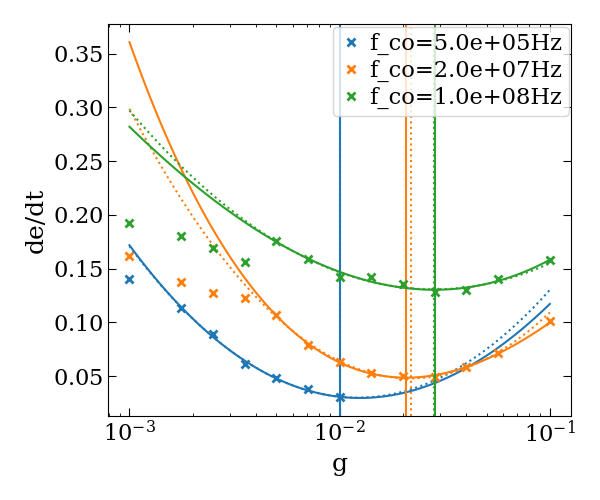

fco=5.0e+05 - minimal dedt = 3.0143e-02 at f=5.0e+05, g=1.00e-02 |  1.00 & 0.0301
6 points
Qp=15, fco=5.0e+05, g,dedtmin= 1.000 & 0.03074 | err = 1.8e-03 [0.023 0.199 0.469] [0.003 0.038 0.103]
Qp=15, fco=5.0e+05, g,dedtmin= 1.000 & 0.03069 | err = 1.8e-03 [ 0.019  0.17   0.4   -0.02 ] [0.063 0.571 1.339 0.43 ]
fco=2.0e+07 - minimal dedt = 4.9406e-02 at f=2.0e+07, g=2.83e-02 |  2.83 & 0.0494
8 points
Qp=15, fco=2.0e+07, g,dedtmin= 2.177 & 0.04780 | err = 1.4e-03 [0.026 0.202 0.435] [0.001 0.009 0.018]
Qp=15, fco=2.0e+07, g,dedtmin= 2.072 & 0.04851 | err = 9.6e-04 [ 0.016  0.13   0.291 -0.107] [0.004 0.028 0.057 0.053]
fco=1.0e+08 - minimal dedt = 1.2821e-01 at f=1.0e+08, g=2.83e-02 |  2.83 & 0.1282
8 points
Qp=15, fco=1.0e+08, g,dedtmin= 2.800 & 0.13065 | err = 2.9e-03 [0.015 0.107 0.322] [0.002 0.019 0.039]
Qp=15, fco=1.0e+08, g,dedtmin= 2.826 & 0.13028 | err = 2.9e-03 [0.02  0.134 0.382 0.054] [0.028 0.152 0.323 0.253]


In [36]:
# Find minimum dedt
plt.figure()

g = np.logspace(-3,-1,100)
def fit1(g,a,b,c,d):
    return a*g**2/(b+g**2) + c/(d+g**2)
def fit2(g,a,b,c):
    return (a*g**2+c)/(b+g**2)
def fit3(g,a,b,c,d):
    return a*g**2+b/g**2 + c + d+g**4
def fit31(g,a,b,c,d,e):
    return (a+np.exp(-b*g+e)) / (1+np.exp(-c*g+d))


def fit4(glog,a,b,c,d):
    return (glog-a)**2*b+c+d*glog
def fit41(glog,a,b,c):
    return a*glog**2+b*glog+c
def fit42(glog,a,b,c,d):
    return (a*glog**3+b*glog**2+c*glog)/glog*np.exp(d*glog)

def fit5(glog,a,b,c,d):
    return spec.expit(glog*a+b)*c #- spec.expit(glog*c)*d


for i,fco in enumerate([5e5,2e7,1e8]):
    if study%2==1:
        pass
    else:
        DEDTX = DEDTXTOT
    mask = np.nanargmax(1/DEDTX*(X==fco))
    print('fco=%.1e - minimal dedt = %.4e at f=%.1e, g=%.2e |  %.2f & %.4f'%(
            fco,DEDTX[mask],X[mask],Y[mask],Y[mask]*1e2,DEDTX[mask]))
    Ymin = Y[mask] /np.sqrt(2)
    sepmax = 4.1

    mask = (X==fco)
    x= Y[mask]
    y= DEDTX[mask]
    plt.plot(x,y,'x',c=colors[i],label='f_co=%.1eHz'%fco)
    
    mask = (x>Ymin/sepmax)*(x<sepmax*Ymin)
    x=x[mask] ; y=y[mask]
    
    mask = np.isfinite(y)
    x=x[mask] ; y=y[mask]
#         print(x,)
        
    
    xlog = np.log(x)
    glog = np.log(g)
    print('%d points'%np.size(x))
#     popt,pcov = sc.optimize.curve_fit(fit1,x,y,p0=[1,.1,4,.1])#,bounds=(0,np.inf),method='dogbox')
#     print(popt)
#     plt.plot(g,fit1((g),popt[0],popt[1],popt[2],popt[3]),c=colors[i])

#     popt,pcov = sc.optimize.curve_fit(fit2,x,y,bounds=(0,np.inf))
#     print(popt)
#     plt.plot(g,fit2(g,popt[0],popt[1],popt[2]),'--',c=colors[i+0])
    
#     popt,pcov = sc.optimize.curve_fit(fit31,(x),y,maxfev=10**5)#,method='trf')#,bounds=(0,np.inf),method='dogbox')
#     popt,pcov = sc.optimize.curve_fit(fit31,(x),y,p0 = [0,300,30,300,30],maxfev=10**5,bounds=(0,np.inf))#,method='trf')#,bounds=(0,np.inf),method='dogbox')
#     print(popt)
#     plt.plot(g,fit31((g),popt[0],popt[1],popt[2],popt[3],popt[4]),c=colors[i])

    for j in range(2):
        if j==0:
            popt,pcov = sc.optimize.curve_fit(fit41,xlog,y,maxfev=5000)
            func = lambda x: fit41(np.log(x),popt[0],popt[1],popt[2])
        else:
            popt,pcov = sc.optimize.curve_fit(fit42,xlog,y,maxfev=5000)
            func = lambda x: fit42(np.log(x),popt[0],popt[1],popt[2],popt[3])
        #     print(popt,pcov)
        ls=[':','-'][j]
        plt.plot(g,func(g),ls,c=colors[i+0])
#         gopt = np.exp(-popt[1]/popt[0]/2)
        gopt= sc.optimize.fmin(func,1e-2,ftol=1e-12,disp=False)[0];
#         print('test',gopt)
        gopt = min(gopt,np.max(x))
        dedtmin = func(gopt)
        plt.axvline(gopt,c=colors[i+0],ls=ls)
        errs = np.sqrt(np.diag(pcov))
    #     gopt2 = np.exp(-(popt[1]-errs[1])/(popt[0]+errs[0])/2)
    #     print(popt,popt+errs)
    #     print(gopt,np.exp(-(popt[1]+errs[1])/(popt[0])/2),np.exp(-(popt[1])/(popt[0]-errs[0])/2))
        print('Qp=%.0f, fco=%.1e, g,dedtmin= %.3f & %.5f | err = %.1e'%(
                chroma,fco,gopt*100,dedtmin,np.std(y-func(x))), popt,errs)
    
#     popt= np.polyfit(x,y,deg=2)
#     gopt = -popt[1]/popt[0]/2
#     print(gopt)
#     plt.plot(g,g**2*popt[0]+g*popt[1]+popt[2])
#     popt,pcov = sc.optimize.curve_fit(fit5,xlog,y)
#     print(popt)
#     plt.plot(g,fit5(glog,popt[0],popt[1],popt[2],popt[3]),'-',c=colors[i+0])
    
#     func  = interpolate.interp1d(x,y,kind='quadratic',bounds_error=False)
#     plt.plot(g,func(g))
    
    plt.xscale('log')
# plt.plot(g,spec.expit(g*1e3-1e3),'k')
# plt.ylim(-.1,1)
plt.xlabel('g')
plt.ylabel('de/dt')
plt.legend(loc=0)
plt.tight_layout()

[5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08
 5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08
 5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08
 5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08
 2.0e+07 2.5e+07 5.0e+07 1.0e+08]


<IPython.core.display.Javascript object>


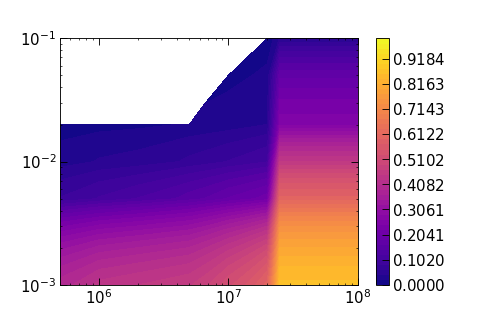

<IPython.core.display.Javascript object>


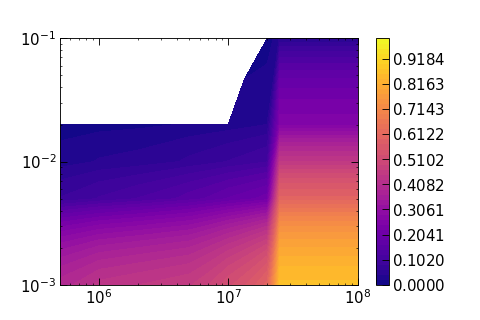

[[0.399 0.436 0.449 0.466 0.525 0.599 0.863 0.863 0.863]
 [0.241 0.27  0.286 0.31  0.355 0.408 0.731 0.731 0.731]
 [0.083 0.104 0.124 0.154 0.186 0.216 0.6   0.6   0.6  ]
 [0.03  0.043 0.049 0.066 0.083 0.101 0.449 0.449 0.449]
 [0.009 0.012 0.015 0.023 0.03  0.041 0.256 0.256 0.256]
 [  nan   nan   nan   nan 0.014 0.026 0.176 0.176 0.176]
 [  nan   nan   nan   nan   nan 0.002 0.043 0.043 0.043]]
[[0.399 0.436 0.449 0.466 0.525 0.599 0.863 0.863 0.863]
 [0.083 0.104 0.124 0.154 0.186 0.216 0.6   0.6   0.6  ]
 [0.03  0.043 0.049 0.066 0.083 0.101 0.449 0.449 0.449]
 [0.009 0.012 0.015 0.023 0.03  0.041 0.256 0.256 0.256]
 [  nan   nan   nan   nan   nan 0.002 0.043 0.043 0.043]]
[5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08] [5.0e+05 1.0e+06 2.0e+06 5.0e+06 1.0e+07 2.0e+07 2.5e+07 5.0e+07 1.0e+08]
[0.001 0.005 0.01  0.02  0.1  ] [0.001, 0.003, 0.005, 0.01, 0.02, 0.05, 0.1]


In [137]:
#Interpolation of points
from scipy.interpolate import griddata
fcosGrid = fcos #np.array([5e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,12e6,14e6,16e6,18e6,2e7,1e8])
gainGrid = [1e-3,3e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
xx,yy = np.meshgrid(fcosGrid,gainGrid)
Z = DEDTX.flatten()
ind = np.logical_and(np.isfinite(Z),X.flatten()<=2e8)
zz = griddata((X.flatten()[ind],Y.flatten()[ind]),Z[ind], (xx,yy),method='linear',rescale=True)
print(X.flatten()[ind])
for i in range(2):
    plt.figure()
    levels = np.linspace(0,1,50)
    plt.contourf([xx,X][i],[yy,Y][i],[zz,DEDTX][i],levels=levels)
        
    plt.yscale('log') ; plt.xscale('log')
    plt.colorbar()
    
print(zz)
print(DEDTX)
print(fcos,fcosGrid)
print(gains,gainGrid)


In [74]:
Relative error Qp=0
 [[-0.004 -0.016  0.032  0.047  0.009 -0.007 -0.051]
 [ 0.005  0.014  0.078  0.061  0.069  0.095 -0.014]
 [-0.013  0.033  0.025  0.005 -0.018  0.03   0.08 ]
 [   nan    nan  0.008 -0.     0.02   0.023 -0.   ]
 [   nan    nan    nan    nan    nan -0.001  0.005]] 0.03342894305551681
    
Relative error Qp=15
 [[ 0.138  0.04   0.056 -0.076 -0.026  0.016  0.061]
 [-0.015  0.001  0.018 -0.002  0.04   0.024 -0.025]
 [ 0.02   0.015  0.008 -0.008  0.017 -0.006  0.017]
 [ 0.015 -0.011  0.014 -0.012 -0.005  0.006 -0.018]
 [   nan    nan    nan    nan    nan  0.008 -0.001]] 0.035022638909145545

SyntaxError: invalid syntax (<ipython-input-74-9da2392a1b24>, line 1)

In [590]:
# plt.figure()
# ax=plt.gca()
# plt.yscale('log')
# plt.xscale('log')
# CS2 = ax.contour(XT,YT,MAXG,levels =MAXGlevels,colors='k')#locator=plt.LogLocator())
# ax.clabel(CS2, CS2.levels,inline=True,inline_spacing=0,fmt='%.2f')#, fmt=fmt)

folders = ["nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS3.28e0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8",
          "nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS1.18e0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8",
          "nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS1.18e0_Qp15_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8",
          "nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS3.28e0_Qp15_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8"]

for folder2 in folders:
    fname = folder1 + folder2

    pp_B1,pp_B2 = postprocess_gather(folder1+folder2,flag_print=~flag_print)
    if np.size(pp_B1[1])>0:
        out_unstable = 0
        try:
            with open(glob.glob(folder1+folder2+'/out*')[0],'r') as outfile:
                out=outfile.read()
#                     if g==1e-1:
#                         print(fco,out.find('unstable in'))
            out_unstable = out.find('unstable in')>0
            print(out_unstable)
        except:
            pass

#         if np.any(pp_B1[6]<1e8)  or out_unstable: #np.any((pp_B1[1]-1*pp_B1[3]) /eps_rel > 6):
#             if ~flag_print: print('Unstable',folder2,pp_B1[6])
#         else:
        dedt = np.mean((pp_B1[1]-1*pp_B1[3]) /eps_rel)
        dedt2 = np.mean((pp_B2[1]-1*pp_B2[3]) /eps_rel)
        print(folder2,dedt,dedt2)
    else:
        if flag_print: print('Not done simulating')


Number of bunches: 128 128
False
nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS3.28e0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8 0.27331107777818714 0.2775400645555968
Number of bunches: 128 128
False
nb128_Np1e6_T1e5_g0_mode10-4_OPa0_OPb0_BBS1.18e0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.122e4_fco1.0e8 0.5936910352520035 0.5955569017094795
Number of bunches: 0 0
Number of bunches: 0 0


-1

<IPython.core.display.Javascript object>


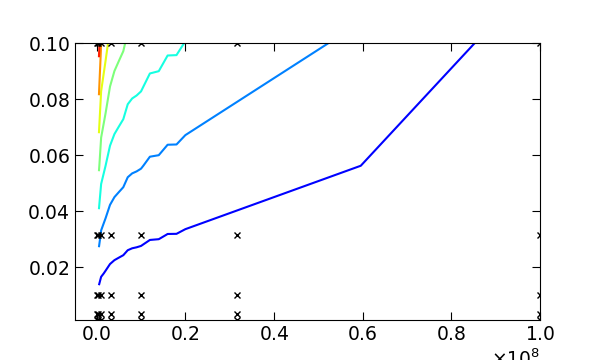

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [952]:

sig_BPM=1e-1
delay=1 ; mode= 2

fig=plt.figure()
fig.set_size_inches(figwidth, figheight*0.9)
val1s = np.logspace(-3,-1,5)
val2s = np.logspace(5,8,7)
# val2s = np.logspace(3,8,11)
X,Y = np.meshgrid(val2s,val1s)
vmin=0 ;
levels = np.linspace(vmin,vmax,100)

if study==3:
    # In separate simulation
    DEDTX = np.zeros_like(X)-1
    print(np.shape(DEDTX))
    for i ,g in enumerate(val1s):
        for j,fco in enumerate(val2s):
            # g = val1s[i]
            # fco = val2s[j]pp_B1,pp_B2 = postprocess_gather(folder1+folder2)
            folder2 = 'nb64_Np1e6_T1e5_g%s_mode%d-%d_OPa1.0e-3_OPb-7.0e-4_Qp0_dx0_LF%s_HF%s_BPM%s_fco%s'%(
                            sci(g,1),mode,delay,sci(sig_LF,1),sci(sig_HF,1),sci(sig_BPM,1),sci(fco,1))
            print(folder2)
            pp_B1,pp_B2 = postprocess_gather(folder1+folder2)
            if np.size(pp_B1[1])>0:
                if np.any(pp_B1[6]<1e8):
                    DEDTX[i,j] = np.nan
                    print('Unstable',folder2)
                else:
                    if i<2:
                        print(pp_B1[1])
                    DEDTX[i,j] = np.mean((pp_B1[1]-1*pp_B1[3]) /eps_rel)
            else:
                print('Not done simulating')

    print(DEDTX)
    plt.contourf(X,Y,DEDTX,extend='both',levels=levels,)#,cmap=cmap)
    np.savetxt('temp_dedt%d%d%d.txt'%(sig_LF>0,sig_HF>0,sig_BPM>0),DEDTX)

plt.plot(X,Y,'xk',ms=4,mew=1)
# plt.ylim(top=10**(7.5))
cb = plt.colorbar(label=r'$\langle\dot{ϵ}\rangle/\dot{ϵ}_\mathrm{ref}$',ticks = np.arange(vmin,vmax+0.1,2))
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.xscale("log")
plt.yscale("log")
ax=plt.gca()
plt.xlabel(r'$f_\mathrm{cutoff}$ [Hz]')
if 1:
    ax.set_xticks([5e5,1e6,2e6,5e6,1e7,2e7,1e8])
    ax.set_xticklabels(['$0.5$','$1$','$2$','$5$','$10$','$20$','Ext. BW'])
    plt.xlabel(r'$f_\mathrm{cutoff}$ [MHz]')
plt.ylabel(r'$g$ (single bunch)')   
# plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

In [ ]:
calc_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3
_reDQx-1.5e-03_imDQx1.3e-04_finda1101_Nc700r_tmax3s_S0
Found alpha!=1, alpha=9.57e-01 -2.11e-01j |  dampDQ = -1.02e-03 -2.072e-04j -> -1.10e-03 -1.898e-04j
Latency (x) = 0.97 s = 9.720423e-01

calc_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3
_reDQx-1.5e-03_imDQx1.3e-04_finda110_Nc700r_tmax10s_S0
Found alpha!=1, alpha=9.57e-01 -2.11e-01j |  dampDQ = -1.02e-03 -2.072e-04j -> -1.06e-03 -1.983e-04j
Latency (x) = 1.71 s = 1.710447e+00


In [637]:
fmax_LF = 891 * frev
fco = 1e6
fcoh = fmax_LF - 0.31*frev

folder2 = dir_name2(nb,npart,nturn,g,gmode,gdelay,a,b,softgauss_Scale,chroma,Qs,
                  sep,fmax_LF,sig_LF,sig_HF,sig_BPM,fco)
print(i,folder2)
fname = folder1 + folder2

# Get COMBI results
pp_B1,pp_B2 = postprocess_gather(fname)
if np.size(pp_B1)+np.size(pp_B2)>0:
    dedt_combi = np.mean((pp_B1[1]-1*pp_B1[3])) / eps_rel
    
print(dedt_combi)


# Get theory
Ntilde,LL,_ = getNtildeLL(bunches,gmode,fco,dt,fcoh = fcoh,a=a,b=b,bb_param=bb_param,g=g)
dedt_theory1 = np.mean(LL)
print(dedt_theory1)

Ntilde2,LL2,_ = getNtildeLL2(bunches,gmode,fco,dt,frev=frev,fmax=fmax_LF,a=a,b=b,bb_param=bb_param,g=g)
dedt_theory2 = np.mean(LL2)
print(dedt_theory2)

6 nb128_Np1e6_T1e5_g1.0e-2_mode2-4_OPa1.1e-3_OPb-7.6e-4_BBS0_Qp0_dx0_HF0_BPM0_LF1.0e-3-fmax1.000e7_fco1.0e6
Number of bunches: 128 0
0.50890402978698
getNtildeLL 0.00109 -0.000763 0.0 0.01


/home/sfuruset/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0.8463854838920406
getNtildeLL 0.00109 -0.000763 0.0 0.01
0.5200459746785275
